In [53]:
import cv2
import mediapipe as mp
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

import os
import sys
import librosa
import random
from matplotlib.widgets import Slider
from IPython.display import Audio
import pandas as pd
from scipy.interpolate import splrep, splev
from scipy.signal import argrelextrema, butter, filtfilt, sosfilt

%matplotlib inline

mp_pose = mp.solutions.pose

# Gestures

## Symmetry

Postural Symmetry checks are implemented as follow:

$hs(t_{i})$ = $\displaystyle \frac{||x^{tc}(t_{i})-x^{LH}(t_{i})|-|x^{tc}(t_{i})-x^{RH}(t_{i})||}{|x^{tc}(t_{i})-x^{LH}(t_{i})|+|x^{tc}(t_{i})-x^{RH}(t_{i})|}$

$vs(t_{i})$ = $\displaystyle \frac{||y^{tc}(t_{i})-y^{LH}(t_{i})|-|y^{tc}(t_{i})-y^{RH}(t_{i})||}{|y^{tc}(t_{i})-y^{LH}(t_{i})|+|y^{tc}(t_{i})-y^{RH}(t_{i})|}$

where hands are $p^{LH}$ and $p^{RH}$, and barycenter with $p^{tc}$

**Input Window**: Symmetry computed considering one frame at the time

**Output Window**: Final prediction computed by checking the most frequent prediction in the last_frames_considered ones (at the moment initialized to 50) 

In [54]:
def compute_asymmetry(lhand, rhand, spine, axis):
    return abs(abs(spine[axis] - lhand[axis])-abs(spine[axis] - rhand[axis]))/abs(abs(spine[axis] - lhand[axis])+abs(spine[axis] - rhand[axis]))

In [55]:
def is_pose_symmetric(lhand, rhand, spine,threshold=0.16):
        
    h_asymmetry = compute_asymmetry(lhand, rhand, spine, "x")
    v_asymmetry = compute_asymmetry(lhand, rhand, spine, "y")

    asymmetry_score = (h_asymmetry + v_asymmetry) / 2

    if(asymmetry_score<threshold):
        return True
    else:
        return False

In [56]:
use_webcam = False #False to use a stored video
previous_symmetries_prediction=[] #prediction based on single frame
last_frames_considered = 50
previous_symmetries_prediction_cleaned=[] #prediction based on last last_frames_considered frames

if use_webcam:
    cap = cv2.VideoCapture(cv2.CAP_DSHOW)
else:
    video_path = 'GestureFeatureResources/video.mov'
    cap = cv2.VideoCapture(video_path)

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        
        if frame is None: # if stored video is finished, exit
            break
            
        if use_webcam:
            frame = cv2.flip(frame, 1)

        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      
        # Make detection
        results = pose.process(image)
    
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
        except:
            print("Error extracting landmarks")
            break
        
        # Indices for wrists and hips
        left_wrist_index = 15
        right_wrist_index = 16
        left_hip_index = 23
        right_hip_index = 24
        
        # Draw circles at previous landmarks
        for index in [left_wrist_index, right_wrist_index, left_hip_index, right_hip_index]:
            landmark = landmarks[index]
            height, width, _ = frame.shape
            cx, cy = int(landmark.x * width), int(landmark.y * height)
            cv2.circle(frame, (cx, cy), 5, (255, 0, 0), -1)  # Draw a circle at the landmark position
        
        spine = {'x': 0.0, 'y': 0.0} #spine (point between hips), assumed to be the barycenter
        spine["x"] = int(((landmarks[left_hip_index].x * width) + (landmarks[right_hip_index].x * width)) / 2)
        spine["y"] = int(((landmarks[left_hip_index].y * height) + (landmarks[right_hip_index].y * height)) / 2)
        cv2.circle(frame, (spine["x"], spine["y"]), 5, (0, 0, 255), -1)  # Draw a circle at the landmark position

        
        # Connect wrists with spine
        cv2.line(frame, (int(landmarks[left_wrist_index].x * width), int(landmarks[left_wrist_index].y * height)),
                 (int(spine["x"]), int(spine["y"])),
                 (0, 255, 0), 2)

        cv2.line(frame, (int(landmarks[right_wrist_index].x * width), int(landmarks[right_wrist_index].y * height)), 
                 (int(spine["x"]), int(spine["y"])),
                 (0, 255, 0), 2)     
        
        # Prediction
        l_hand = {'x':landmarks[left_wrist_index].x*width, 'y':landmarks[left_wrist_index].y*height}
        r_hand = {'x':landmarks[right_wrist_index].x*width, 'y':landmarks[right_wrist_index].y*height}

        symmetry_prediction_single_frame = is_pose_symmetric(l_hand,r_hand,spine)
        
        
        previous_symmetries_prediction.append(symmetry_prediction_single_frame)   
        
        #count if there are more symmetries or asymmetries frames in last specified
        previous_symmetries_prediction_cleaned.append(len([elem for elem in previous_symmetries_prediction[-last_frames_considered:] if elem]) > len([elem for elem in previous_symmetries_prediction[-last_frames_considered:] if not elem]))

        # Prediction box
        if(previous_symmetries_prediction_cleaned[-1]):
            rect_color=(255,0,0)
            rect_text="Symmetric"
        else:
            rect_color=(0,0,255)
            rect_text="Non Symmetric"

        cv2.rectangle(frame, (0,0), (270,100), rect_color, -1)
        
        cv2.putText(frame,rect_text, 
                    (10,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)


        cv2.imshow('Mediapipe Feed', frame)

        #stop predictions when 'q' is pressed
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

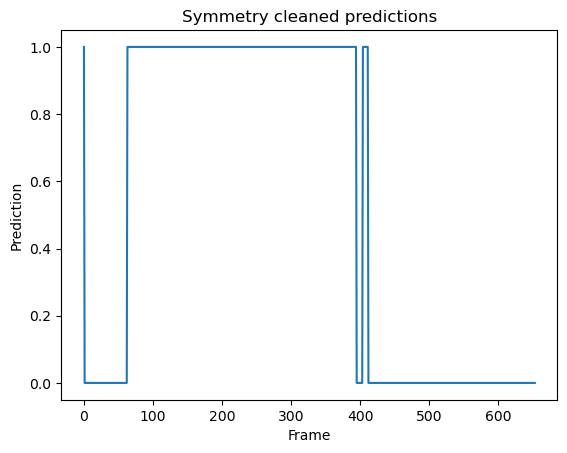

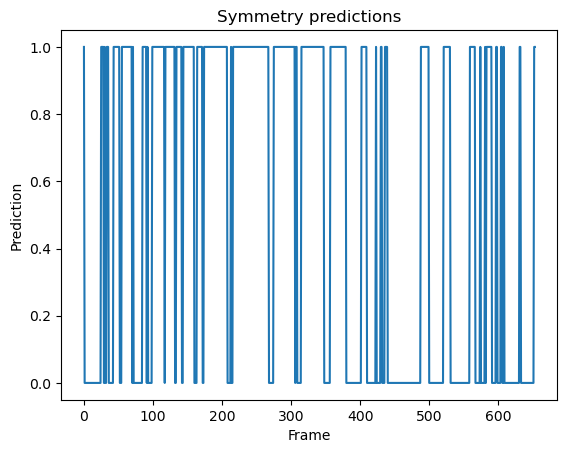

In [57]:
# Plotting Graphs
plt.figure()
plt.plot(range(len(previous_symmetries_prediction_cleaned)), previous_symmetries_prediction_cleaned)
plt.xlabel("Frame")
plt.ylabel("Prediction")
plt.title("Symmetry cleaned predictions")
plt.show()

plt.figure()
plt.plot(range(len(previous_symmetries_prediction)), previous_symmetries_prediction)
plt.xlabel("Frame")
plt.ylabel("Prediction")
plt.title("Symmetry predictions")
plt.show()

# Compactness

Compactness is computed as follow. No distance_from_camera-based normalizations are done because the interest is related not to a compactness index in absolute values, but only on its variation

$as(t_{i})$ = $||p^{H}(t_{i})-p^{SP}(t_{i})||$

Arm shape: Magnitude of the vector from hand (taken as landmark $p^{H}$) to base of the spine (landmark $p^{SP}$) :

**Input Window**: Compactness computed considering one frame at the time

**Output Window**: Final prediction computed by checking if the current compactness index is, on avarage, higher or lower of the last_frames_considered ones (at the moment initialized to 15) 

In [58]:
def compute_volume_variation(lhand, rhand, spine):
    volume = 0
    
    for hand in [lhand, rhand]:
        # Compute the vector from hand to base of the spine
        vector_x = spine["x"] - hand["x"]
        vector_y = spine["y"] - hand["y"]

        # Compute the magnitude of the vector
        volume = volume + math.sqrt(vector_x**2 + vector_y**2)
    
    return volume

In [59]:
use_webcam = False #False to use a stored video

if use_webcam:
    cap = cv2.VideoCapture(0)
else:
    video_path = 'GestureFeatureResources/video.mov'
    cap = cv2.VideoCapture(video_path)

previous_volumes=[] #volumes of each frame
last_frames_considered = 15
previous_predictions=[] #predictions, based on last_frames_considered volumes, of each frame

# Setup mediapipe instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        
        if frame is None: # if stored video is finished, exit
            break
            
        if use_webcam:
            frame = cv2.flip(frame, 1)

        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      
        # Make detection
        results = pose.process(image)
    
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
        except:
            print("Error extracting landmarks")
            break
        
        # Indices for the nose, shoulders, elbows, and wrists
        left_wrist_index = 15
        right_wrist_index = 16
        left_hip_index = 23
        right_hip_index = 24
        
        # Draw circles at specific landmarks
        for index in [left_wrist_index, right_wrist_index, left_hip_index, right_hip_index]:
            landmark = landmarks[index]
            height, width, _ = frame.shape
            cx, cy = int(landmark.x * width), int(landmark.y * height)
            cv2.circle(frame, (cx, cy), 5, (255, 0, 0), -1)  # Draw a circle at the landmark position
        
        spine = {'x': 0.0, 'y': 0.0}
        spine["x"] = int(((landmarks[left_hip_index].x * width) + (landmarks[right_hip_index].x * width)) / 2)
        spine["y"] = int(((landmarks[left_hip_index].y * height) + (landmarks[right_hip_index].y * height)) / 2)
        cv2.circle(frame, (spine["x"], spine["y"]), 5, (0, 0, 255), -1)  # Draw a circle at the landmark position

        
        # Connect wrists with spine
        cv2.line(frame, (int(landmarks[left_wrist_index].x * width), int(landmarks[left_wrist_index].y * height)),
                 (int(spine["x"]), int(spine["y"])),
                 (0, 255, 0), 2)

        cv2.line(frame, (int(landmarks[right_wrist_index].x * width), int(landmarks[right_wrist_index].y * height)), 
                 (int(spine["x"]), int(spine["y"])),
                 (0, 255, 0), 2)        

        
        # Compute body volume
        l_hand = {'x':landmarks[left_wrist_index].x*width, 'y':landmarks[left_wrist_index].y*height}
        r_hand = {'x':landmarks[right_wrist_index].x*width, 'y':landmarks[right_wrist_index].y*height}
        
        volume = compute_volume_variation(l_hand,r_hand,spine)
                                          
        # Check if the current volume is greater or lower the previous last_frames_considered ones, in order to make a prediction
        last_n_volumes = previous_volumes[-last_frames_considered:]
        greater_count = sum(1 for element in last_n_volumes if element > volume)
        lower_count = sum(1 for element in last_n_volumes if element < volume)
         
        previous_volumes.append(volume)   

        #Prediction computation
        if(greater_count < lower_count):
            previous_predictions.append(True)
        else:
            previous_predictions.append(False)

        # Prediction box    
        if(previous_predictions[-1]):
            rect_color=(255,0,0)
            rect_text="Increasing volume"
        else:
            rect_color=(0,0,255)
            rect_text="Decreasing volume"

        cv2.rectangle(frame, (0,0), (270,100), rect_color, -1)
        
        cv2.putText(frame,rect_text, 
                    (10,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

        cv2.imshow('Mediapipe Feed', frame)
        
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

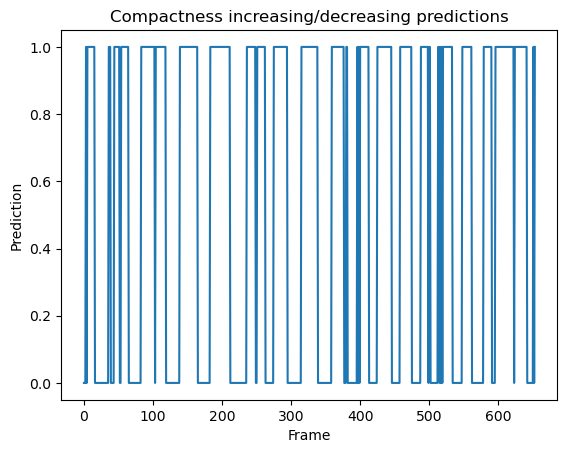

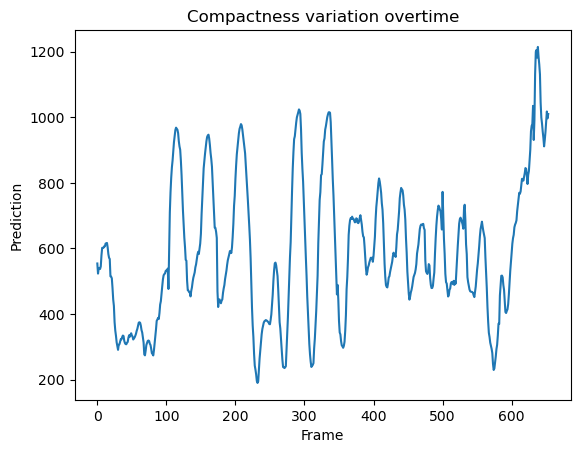

In [60]:
# Plotting Graphs
plt.figure()
plt.plot(range(len(previous_predictions)), previous_predictions)
plt.xlabel("Frame")
plt.ylabel("Prediction")
plt.title("Compactness increasing/decreasing predictions")
plt.show()

plt.figure()
plt.plot(range(len(previous_volumes)), previous_volumes)
plt.xlabel("Frame")
plt.ylabel("Prediction")
plt.title("Compactness variation overtime")
plt.show()

# Wrist speed

The velocity of each wrist is computed in the following way:

$v^{k}(t_{i})$ = $\displaystyle \frac{p^{k}(t_{i})-p^{k}(t_{i-last\_frames\_considered})}{t_{i}-t_{i-last\_frames\_considered}}$

Their speed is computed as:
$v^{k}(t_{i})$ = $\sqrt{(v^{k}_{x}(t_{i}))^2+(v^{k}_{y}(t_{i}))^2}$

**Input Window**: Speed computed considering comparing the actual position with the one of last_frames_considered frames ago (last_frames_considered is initialized to 2)

**Output Window**: Final prediction computed by smoothing the raw one with a convolution composed by the average over the window of window_size elements (at the moment initialized to 30)

In [61]:
# the implementation assumes that all _past and _now couples used have the same temporal distance between them

def compute_speed(lhand_past, lhand_now, rhand_past, rhand_now,dt):
    
    # Compute the speed of left and right hand
    speed_lhand = math.sqrt(((lhand_past["x"] - lhand_now["x"])/dt)**2 + ((lhand_past["y"] - lhand_now["y"])/dt)**2)
    speed_rhand = math.sqrt(((rhand_past["x"] - rhand_now["x"])/dt)**2 + ((rhand_past["y"] - rhand_now["y"])/dt)**2)
    
    return round((speed_lhand + speed_rhand),2)

In [62]:
use_webcam = False #False to use a stored video
last_frames_considered = 2 #eventually used to reduce noise
speed = None

if use_webcam:
    cap = cv2.VideoCapture(0)
    sec_betw_last_frames_considered = 1 #cannot be evaluated with webcam

else:
    video_path = 'GestureFeatureResources/video.mov'
    cap = cv2.VideoCapture(video_path)

    fps = cap.get(cv2.CAP_PROP_FPS)
    sec_betw_last_frames_considered = (1/fps)*last_frames_considered

speed_predictions=[] #predictions containg instantaneous speed
lhand_previous_positions=[]
rhand_previous_positions=[]

# Setup mediapipe instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()

        if frame is None: # if stored video is finished, exit
            break

        if use_webcam:
            frame = cv2.flip(frame, 1)

        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      
        # Make detection
        results = pose.process(image)
    
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
        except:
            print("Error extracting landmarks")
            break

        
        # Indices for the nose, shoulders, elbows, and wrists
        left_wrist_index = 15
        right_wrist_index = 16
        
        # Draw circles at specific landmarks
        if(len(lhand_previous_positions)>=last_frames_considered):
            for hand in lhand_previous_positions[-last_frames_considered:]+rhand_previous_positions[-last_frames_considered:]:
                cv2.circle(frame, (int(hand["x"]), int(hand["y"])), 3, (0, 255, 0), -1)  # Draw a circle at the landmark position              

            
        for index in [left_wrist_index, right_wrist_index]:
            landmark = landmarks[index]
            height, width, _ = frame.shape
            cx, cy = int(landmark.x * width), int(landmark.y * height)
            cv2.circle(frame, (cx, cy), 5, (255, 0, 0), -1)  # Draw a circle at the landmark position              

        
        # Compute body volume
        lhand = {'x':landmarks[left_wrist_index].x*width, 'y':landmarks[left_wrist_index].y*height}
        rhand = {'x':landmarks[right_wrist_index].x*width, 'y':landmarks[right_wrist_index].y*height}
        
        #computed with second last position to reduce noise
        if(len(lhand_previous_positions)>=last_frames_considered):
            speed = compute_speed(lhand_previous_positions[-last_frames_considered],lhand,rhand_previous_positions[-last_frames_considered],rhand,sec_betw_last_frames_considered)
            speed_predictions.append(speed)
        
        lhand_previous_positions.append(lhand)    
        rhand_previous_positions.append(rhand)                               

        # Prediction box
        if speed is not None:
            cv2.rectangle(frame, (0,0), (270,100), (255,0,0), -1)

            cv2.putText(frame,'Speed: '+str(speed), 
                        (10,60), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

        cv2.imshow('Mediapipe Feed', frame)
        
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

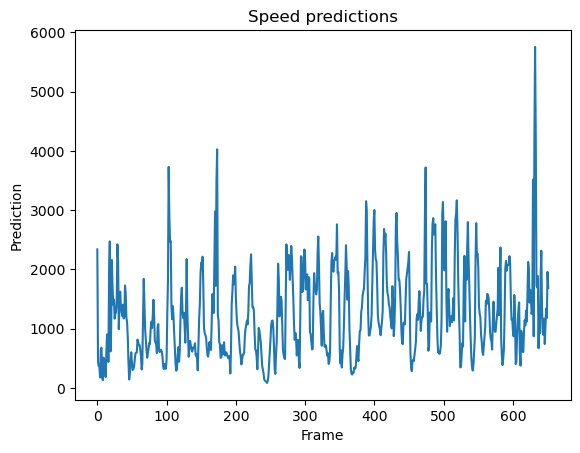

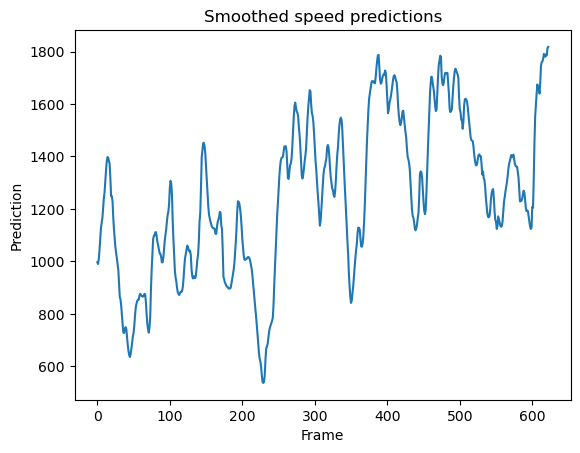

In [63]:
# Plotting Graphs
plt.figure()
plt.plot(range(len(speed_predictions)), speed_predictions)
plt.xlabel("Frame")
plt.ylabel("Prediction")
plt.title("Speed predictions")
plt.show()

window_size = 30
smoothed_prediction = np.convolve(speed_predictions, np.ones(window_size)/window_size, mode='valid')
plt.figure()
plt.plot(range(len(smoothed_prediction)), smoothed_prediction)
plt.xlabel("Frame")
plt.ylabel("Prediction")
plt.title("Smoothed speed predictions")
plt.show()

# Wrist trajectory

Foreach wrist, its trajectory is computed as 

$d^{k}(t_{i})$ = $\displaystyle \frac{p^{k}(t_{i})-p^{k}(t_{i-last\_frames\_considered})}{||p^{k}(t_{i})-p^{k}(t_{i-last\_frames\_considered})||}$

**Input Window**: Trajectory computed considering comparing the actual position with the one of last_frames_considered frames ago (last_frames_considered is initialized to 2)

**Output Window**: Final prediction computed by smoothing the raw one with a convolution composed by the average over the window of window_size elements (at the moment initialized to 30)

In [64]:
def compute_trajectory(lhand_past, lhand_now, rhand_past, rhand_now):
    
    # Compute direction of movement of both hands
    direction_lhand_x = round((lhand_now["x"]-lhand_past["x"])/math.sqrt((lhand_now["x"]-lhand_past["x"])**2+(lhand_now["y"]-lhand_past["y"])**2),2)
    direction_lhand_y = round((lhand_now["y"]-lhand_past["y"])/math.sqrt((lhand_now["x"]-lhand_past["x"])**2+(lhand_now["y"]-lhand_past["y"])**2),2)
    direction_rhand_x = round((rhand_now["x"]-rhand_past["x"])/math.sqrt((rhand_now["x"]-rhand_past["x"])**2+(rhand_now["y"]-rhand_past["y"])**2),2)
    direction_rhand_y = round((rhand_now["y"]-rhand_past["y"])/math.sqrt((rhand_now["x"]-rhand_past["x"])**2+(rhand_now["y"]-rhand_past["y"])**2),2)

    return [direction_lhand_x,direction_lhand_y],[direction_rhand_x,direction_rhand_y]

In [65]:
use_webcam = False #False to use a stored video
last_frames_considered = 2 #eventually used to reduce noise
ltrajectory = None
rtrajectory = None

if use_webcam:
    cap = cv2.VideoCapture(0)
else:
    video_path = 'GestureFeatureResources/video.mov'
    cap = cv2.VideoCapture(video_path)

ltrajectory_predictions=[] #predictions containg direction of movement of left wrist
rtrajectory_predictions=[] #predictions containg direction of movement of right wrist
lhand_previous_positions=[]
rhand_previous_positions=[]

# Setup mediapipe instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()

        if frame is None: # if stored video is finished, exit
            break

        if use_webcam:
            frame = cv2.flip(frame, 1)


        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      
        # Make detection
        results = pose.process(image)
    
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
        except:
            print("Error extracting landmarks")
            break
        
        # Indices for the nose, shoulders, elbows, and wrists
        left_wrist_index = 15
        right_wrist_index = 16
        
        # Draw circles for trajectories
        if(len(lhand_previous_positions)>=last_frames_considered):
            for hand in lhand_previous_positions[-last_frames_considered:]+rhand_previous_positions[-last_frames_considered:]:
                cv2.circle(frame, (int(hand["x"]), int(hand["y"])), 3, (0, 255, 0), -1)  # Draw a circle at the landmark position              

        #draw landmark circles
        for index in [left_wrist_index, right_wrist_index]:
            landmark = landmarks[index]
            height, width, _ = frame.shape
            cx, cy = int(landmark.x * width), int(landmark.y * height)
            cv2.circle(frame, (cx, cy), 5, (255, 0, 0), -1)  # Draw a circle at the landmark position
                
        # Compute hand coordinates
        lhand = {'x':landmarks[left_wrist_index].x*width, 'y':landmarks[left_wrist_index].y*height}
        rhand = {'x':landmarks[right_wrist_index].x*width, 'y':landmarks[right_wrist_index].y*height}
        
        #computed trajectories
        if(len(lhand_previous_positions)>=last_frames_considered):
            ltrajectory, rtrajectory= compute_trajectory(lhand_previous_positions[-last_frames_considered],lhand,rhand_previous_positions[-last_frames_considered],rhand)
            
            ltrajectory_predictions.append(ltrajectory)
            rtrajectory_predictions.append(rtrajectory)
        
        lhand_previous_positions.append(lhand)    
        rhand_previous_positions.append(rhand)                               

        # Prediction box
        if ltrajectory is not None:
            cv2.rectangle(frame, (width-270,0), (width,100), (255,0,0), -1)

            cv2.putText(frame,'L: '+str(ltrajectory), 
                        (width-260,60), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
        if rtrajectory is not None:
            cv2.rectangle(frame, (0,0), (270,100), (255,0,0), -1)

            cv2.putText(frame,'R: '+str(rtrajectory), 
                        (10,60), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)


        cv2.imshow('Mediapipe Feed', frame)
        
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

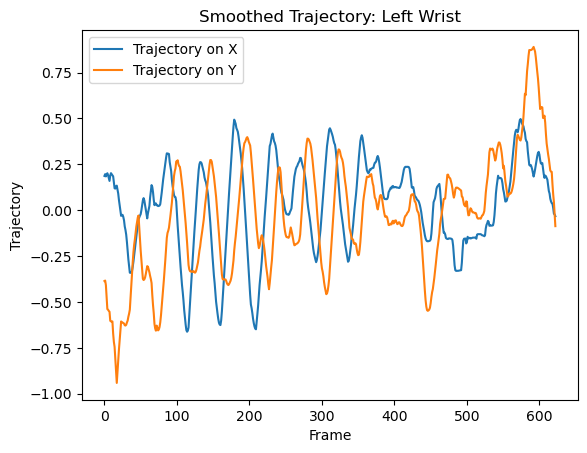

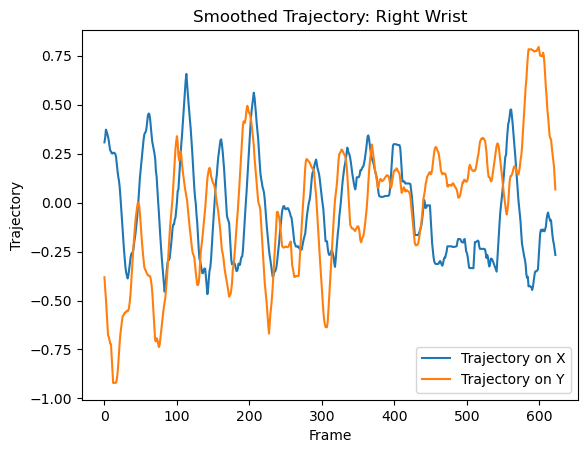

In [66]:
window_size = 30

# Smoothing L
ltrajectory_smoothed={}
ltrajectory_smoothed["x"] = np.convolve([axis[0] for axis in ltrajectory_predictions], np.ones(window_size)/window_size, mode='valid')
ltrajectory_smoothed["y"] = np.convolve([axis[1] for axis in ltrajectory_predictions], np.ones(window_size)/window_size, mode='valid')

# Plotting Graphs
plt.figure()
plt.plot(range(len(ltrajectory_smoothed["x"])), ltrajectory_smoothed["x"], label='Trajectory on X')
plt.plot(range(len(ltrajectory_smoothed["y"])), ltrajectory_smoothed["y"], label='Trajectory on Y')
plt.xlabel("Frame")
plt.ylabel("Trajectory")
plt.title("Smoothed Trajectory: Left Wrist")
plt.legend()
plt.show()

# Smoothing R
rtrajectory_smoothed={}
rtrajectory_smoothed["x"] = np.convolve([axis[0] for axis in rtrajectory_predictions], np.ones(window_size)/window_size, mode='valid')
rtrajectory_smoothed["y"] = np.convolve([axis[1] for axis in rtrajectory_predictions], np.ones(window_size)/window_size, mode='valid')

# Plotting Graphs
plt.figure()
plt.plot(range(len(rtrajectory_smoothed["x"])), rtrajectory_smoothed["x"], label='Trajectory on X')
plt.plot(range(len(rtrajectory_smoothed["y"])), rtrajectory_smoothed["y"], label='Trajectory on Y')
plt.xlabel("Frame")
plt.ylabel("Trajectory")
plt.title("Smoothed Trajectory: Right Wrist")
plt.legend()
plt.show()

# Plotting Graphs
#if(len(rtrajectory_smoothed["x"])==len(ltrajectory_smoothed["x"])): 
#    overall_trajectory_smoothed={"x":[],"y":[]}
#    
#    for elem1, elem2 in zip(rtrajectory_smoothed["x"], ltrajectory_smoothed["x"]):
#        overall_trajectory_smoothed["x"].append((elem1 + elem2)/2)
#        
#    for elem1, elem2 in zip(rtrajectory_smoothed["y"], ltrajectory_smoothed["y"]):
#        overall_trajectory_smoothed["y"].append((elem1 + elem2)/2)
#    
#    
#    plt.figure()
#    plt.plot(range(len(overall_trajectory_smoothed["x"])), overall_trajectory_smoothed["x"], label='Trajectory on X')
#    plt.plot(range(len(overall_trajectory_smoothed["y"])), overall_trajectory_smoothed["y"], label='Trajectory on Y')
#    plt.xlabel("Frame")
#    plt.ylabel("Trajectory")
#    plt.title("Overall mean of Wrists Trajectory")
#    plt.legend()
#    plt.show()

# Classification

Added simple movement classifier:

If (1) the movement analyzed is symmetric and (2) the x component of the wrists trajectory has more prominent peaks and deeper troughs compared to the y one: **Forward shift**

If (1) the movement analyzed is symmetric and (2) the y component of the wrists trajectory has more prominent peaks and deeper troughs compared to the y one: **Backward shift**

If (1) the movement analyzed is asymmetric and (2) the x component of a "row" is mostly positive: **Clockwise (to the left) rotation**

If (1) the movement analyzed is asymmetric and (2) the x component of a "row" is mostly negative: **Anticlockwise (to the right) rotation**

**Early fusion**: The symmetry and the trajectory classifiers are applied on the input data separately as previously described and the most frequent prediction in the last 25 ones is proposed as the final one.

In [67]:
def compute_peaks(trajectory, prev_peak, axis = "x", direction="max"):
    #if over/under of prev peak + if is local max
    if(direction=="max"):
        
        if((trajectory[axis][-2]>prev_peak[direction]) | ((trajectory[axis][-2]>trajectory[axis][-3]) & (trajectory[axis][-2]>trajectory[axis][-1]))):
            return trajectory[axis][-2]
    else:
        if((trajectory[axis][-2]<prev_peak[direction]) | ((trajectory[axis][-2]<trajectory[axis][-3]) & (trajectory[axis][-2]<trajectory[axis][-1]))):
            return trajectory[axis][-2]
   
    return prev_peak[direction]

In [68]:
use_webcam = False #False to use a stored video
last_frames_considered_symmetry = 50
last_frames_considered_trajectory = 2
window_size_convolution = 30
previous_symmetries_prediction=[]
previous_symmetries_prediction_cleaned=[]
movement_class_predictions=[] #movements prediction
movement_class=""


ltrajectory = None
rtrajectory = None

x_peak={"min":1,"max":-1}
y_peak={"min":1,"max":-1}

if use_webcam:
    cap = cv2.VideoCapture(0)
else:
    video_path = 'GestureFeatureResources/video.mov'
    cap = cv2.VideoCapture(video_path)

ltrajectory_predictions=[] #predictions containg direction of movement of left wrist
rtrajectory_predictions=[] #predictions containg direction of movement of right wrist
lhand_previous_positions=[]
rhand_previous_positions=[]

# Setup mediapipe instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()

        if frame is None: # if stored video is finished, exit
            break
            
        if use_webcam:
            frame = cv2.flip(frame, 1)

        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      
        # Make detection
        results = pose.process(image)
    
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
        except:
            print("Error extracting landmarks")
            break
        
        # Indices for the nose, shoulders, elbows, and wrists
        left_wrist_index = 15
        right_wrist_index = 16
        left_hip_index = 23
        right_hip_index = 24
        
        # Draw circles for trajectories
        if(len(lhand_previous_positions)>=last_frames_considered_trajectory):
            for hand in lhand_previous_positions[-last_frames_considered_trajectory:]+rhand_previous_positions[-last_frames_considered_trajectory:]:
                cv2.circle(frame, (int(hand["x"]), int(hand["y"])), 3, (0, 255, 0), -1)  # Draw a circle at the landmark position              

        #draw landmark circles
        for index in [left_wrist_index, right_wrist_index, left_hip_index, right_hip_index]:
            landmark = landmarks[index]
            height, width, _ = frame.shape
            cx, cy = int(landmark.x * width), int(landmark.y * height)
            cv2.circle(frame, (cx, cy), 5, (255, 0, 0), -1)  # Draw a circle at the landmark position
        
        spine = {'x': 0.0, 'y': 0.0} #spine (point between hips), assumed to be the barycenter
        spine["x"] = int(((landmarks[left_hip_index].x * width) + (landmarks[right_hip_index].x * width)) / 2)
        spine["y"] = int(((landmarks[left_hip_index].y * height) + (landmarks[right_hip_index].y * height)) / 2)
        cv2.circle(frame, (spine["x"], spine["y"]), 5, (0, 0, 255), -1)  # Draw a circle at the landmark position

        
        # Connect wrists with spine
        cv2.line(frame, (int(landmarks[left_wrist_index].x * width), int(landmarks[left_wrist_index].y * height)),
                 (int(spine["x"]), int(spine["y"])),
                 (0, 255, 0), 2)

        cv2.line(frame, (int(landmarks[right_wrist_index].x * width), int(landmarks[right_wrist_index].y * height)), 
                 (int(spine["x"]), int(spine["y"])),
                 (0, 255, 0), 2)   
        
        # Compute hand coordinates
        lhand = {'x':landmarks[left_wrist_index].x*width, 'y':landmarks[left_wrist_index].y*height}
        rhand = {'x':landmarks[right_wrist_index].x*width, 'y':landmarks[right_wrist_index].y*height}
        
        #computed trajectories
        if(len(lhand_previous_positions)>=last_frames_considered_trajectory):
            ltrajectory, rtrajectory= compute_trajectory(lhand_previous_positions[-last_frames_considered_trajectory],lhand,rhand_previous_positions[-last_frames_considered_trajectory],rhand)
            
            ltrajectory_predictions.append(ltrajectory)
            rtrajectory_predictions.append(rtrajectory)
        
        lhand_previous_positions.append(lhand)    
        rhand_previous_positions.append(rhand)                               

        l_hand = {'x':landmarks[left_wrist_index].x*width, 'y':landmarks[left_wrist_index].y*height}
        r_hand = {'x':landmarks[right_wrist_index].x*width, 'y':landmarks[right_wrist_index].y*height}

        symmetry_prediction_single_frame = is_pose_symmetric(l_hand,r_hand,spine)
        
        
        previous_symmetries_prediction.append(symmetry_prediction_single_frame)   
        
        #count if there are more symmetries or asymmetries frames in last specified
        previous_symmetries_prediction_cleaned.append(len([elem for elem in previous_symmetries_prediction[-last_frames_considered_symmetry:] if elem]) > len([elem for elem in previous_symmetries_prediction[-last_frames_considered_symmetry:] if not elem]))
        
        # Prediction boxes Trajectories
        if ltrajectory is not None:
            cv2.rectangle(frame, (width-270,0), (width,100), (255,0,0), -1)

            cv2.putText(frame,'L: '+str(ltrajectory), 
                        (width-260,60), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
        if rtrajectory is not None:
            cv2.rectangle(frame, (0,0), (270,100), (255,0,0), -1)

            cv2.putText(frame,'R: '+str(rtrajectory), 
                        (10,60), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

        # Prediction box Symmetry
        if(previous_symmetries_prediction_cleaned[-1]):
            rect_color=(255,0,0)
            rect_text="Symmetric"
        else:
            rect_color=(0,0,255)
            rect_text="Non Symmetric"

        cv2.rectangle(frame, (0,100), (270,200), rect_color, -1)    
        cv2.putText(frame,rect_text, 
                    (10,160), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
        # Classification box
        if(len(ltrajectory_predictions)>window_size_convolution*2+1):
            ltrajectory_smoothed={}
            ltrajectory_smoothed["x"] = np.convolve([axis[0] for axis in ltrajectory_predictions], np.ones(window_size_convolution)/window_size_convolution, mode='valid')
            ltrajectory_smoothed["y"] = np.convolve([axis[1] for axis in ltrajectory_predictions], np.ones(window_size_convolution)/window_size_convolution, mode='valid')

            rtrajectory_smoothed={}
            rtrajectory_smoothed["x"] = np.convolve([axis[0] for axis in rtrajectory_predictions], np.ones(window_size_convolution)/window_size_convolution, mode='valid')
            rtrajectory_smoothed["y"] = np.convolve([axis[1] for axis in rtrajectory_predictions], np.ones(window_size_convolution)/window_size_convolution, mode='valid')

            x_peak["max"] = compute_peaks(ltrajectory_smoothed, x_peak, "x", "max")
            x_peak["max"] = compute_peaks(rtrajectory_smoothed, x_peak, "x", "max")
            x_peak["min"] = compute_peaks(ltrajectory_smoothed, x_peak, "x", "min")
            x_peak["min"] = compute_peaks(rtrajectory_smoothed, x_peak, "x", "min")
            y_peak["max"] = compute_peaks(ltrajectory_smoothed, y_peak, "y", "max")
            y_peak["max"] = compute_peaks(rtrajectory_smoothed, y_peak, "y", "max")
            y_peak["min"] = compute_peaks(ltrajectory_smoothed, y_peak, "y", "min")
            y_peak["min"] = compute_peaks(rtrajectory_smoothed, y_peak, "y", "min")
                        
            #if someone is swimming forward or backward
            if(previous_symmetries_prediction_cleaned[-1]):
                if((x_peak["max"]>y_peak["max"]) & (x_peak["min"]<y_peak["min"])):
                    movement_class_predictions.append("Forward")
                elif ((x_peak["max"]<y_peak["max"]) & (x_peak["min"]>y_peak["min"])):
                    movement_class_predictions.append("Backward")
                else:
                    pass
            else:
                if (x_peak["max"]+x_peak["min"])>0:
                    movement_class_predictions.append("Right")
                else:
                    movement_class_predictions.append("Left")

            last_predictions = movement_class_predictions[-25:]
            counter = Counter(last_predictions)
            try:
                movement_class = counter.most_common(1)[0][0]


                cv2.rectangle(frame, (width-200,height-100), (width,height), (0,255,255), -1)

                cv2.putText(frame,movement_class, 
                            (width-190,height-40), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2, cv2.LINE_AA)
            except:
                pass

        cv2.imshow('Mediapipe Feed', frame)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

       

cap.release()
cv2.destroyAllWindows()

# Breathing Analisys

## Feature Computation Functions

In [69]:
def butter_lowpass_filter(data, cutoff, fs, order = 2):
    nyq = 0.5 * fs # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y
def butter_highpass_filter(data, cut, fs, order=2):
    sos = butter(order, cut, 'hp', fs=fs, output='sos')
    filtered = sosfilt(sos, data)
    return filtered

def zeroCrossing(y):
    zeroCrossingPos = librosa.zero_crossings(y)
    return np.count_nonzero(zeroCrossingPos == True)

def interpToAirflowTime(y, shiftInTime = 0):
    maxTime = time[-1]
    step = maxTime / len(y)
    correspondentTimes = np.arange(shiftInTime, maxTime + shiftInTime, step)
    return np.array(list(map(lambda t: y[np.argmin(np.abs(correspondentTimes - t))], time)))

def splrepToAirflowTime(y, shiftInSamples = 0):

    z = np.zeros(len(y))
    if(shiftInSamples > 0):
        z = np.concatenate([[y[0]]*shiftInSamples, y[:-shiftInSamples]])
    elif(shiftInSamples < 0):
        z = np.concatenate([y[shiftInSamples:], [y[-1]]*shiftInSamples])
    else:
        z = y

    tck = splrep(np.arange(len(z)), z, k=3)
    splevArray = splev(np.linspace(0, len(z) - 1, len(time)), tck)

    return splevArray

def ComputeRMSAllignedToTime(y, sr, windowInSec = 0.04):
    #Extracting rms to have a visual comparison beteen the audio signal and the AirFlow extracted windows windowInSec and hop of 1/2 of window
    hopPercentage = 0.5
    rms_40ms = librosa.feature.rms(y=y, frame_length=int(sr*windowInSec), hop_length=int(sr*windowInSec*hopPercentage), center=True)
    
    return interpToAirflowTime(rms_40ms[0], windowInSec / 2)


def cleanAutocorrelation(y):
    for i, val in enumerate(y):
        if val == invalidValueForAutocorrelation:
            leftIndx = i
            rightIndex = i
            while (y[leftIndx] == invalidValueForAutocorrelation and leftIndx > 0):
                leftIndx-=1
            while (y[rightIndex] == invalidValueForAutocorrelation and rightIndex < len(y) -1):
                rightIndex+=1
            if(y[leftIndx] == invalidValueForAutocorrelation):
                leftIndx = rightIndex
            if(y[rightIndex] == invalidValueForAutocorrelation):
                rightIndex = leftIndx
            y[i] = (y[leftIndx] + y[rightIndex]) / 2
    return y

def computeF0OnWindow(y, sr, i, frame_length, offset = 0):
    if(i+offset < 0):
        offset = -i
    elif(i+frame_length+offset > len(y)):
        offset = len(y) - i -frame_length
        
    frame = y[i+offset:(i+frame_length+offset)]
    autoCorrelation = librosa.autocorrelate(frame)

    tMax = -1
    localMax = argrelextrema(autoCorrelation, np.greater)[0]
    if(len(localMax) > 1):
        tMax = localMax[1]   #I'm Taking the second
    else:
        return invalidValueForAutocorrelation
        
    return float(sr)/float(tMax)
    
def ComputeF0(y, sr, windowInSec = 0.04):
    frame_length = int(sr * windowInSec) # I assume 40ms = 25Hz (windowInSec= 0.04) beign the longer waive that I need, 

    F0s = np.array([
        computeF0OnWindow(y, sr, i, frame_length)
        for i in range(0, len(y), frame_length)
    ])

    F0s = cleanAutocorrelation(F0s)
    
    return interpToAirflowTime(F0s, windowInSec / 2)


def FilterF0(F0s):
    # Filter requirements.
    cutoff = srAirFlow / 50    # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 2 Hz
    order = 2       # sin wave can be approx represented as quadratic
    return butter_lowpass_filter(F0s, cutoff, srAirFlow, 2)

def SubtractBaseLine(y, choosedBreathinFreq, tollerance = 0, recursive_halfOffset = False):
    counter = 0
    baseLine = np.zeros(len(y))
    while(counter < len(y)):
        segmentLength = counter
        maxFreq = choosedBreathinFreq[counter]
        while True:
            if(segmentLength == len(y)):
                break
            maxFreq = np.max([maxFreq, choosedBreathinFreq[segmentLength]])
            if((srAirFlow / maxFreq)*(tollerance +1) < segmentLength - counter):
                break
            segmentLength+=1
        segmentLength-=1
        if(recursive_halfOffset == True and counter == 0):
            counter = segmentLength // 2
        else:
            baseLine[counter:segmentLength+1] = np.min(y[counter:segmentLength])
            counter = segmentLength+1

    if(recursive_halfOffset == True):
        return baseLine

    additionalBaseLine = SubtractBaseLine(y, choosedBreathinFreq, tollerance, True)
    
    baseLine = [ (baseLine[i] + additionalBaseLine[i])/2.0 for i in range(0, len(y))] 

    reduced = np.interp(np.linspace(0, time[-1], len(time) // 100), time, baseLine)

    baseLine = splrepToAirflowTime(reduced)

    return np.subtract(y, baseLine), baseLine
    
    #dataPerWindow = int(window * srAirFlow)
    #hop = int(dataPerWindow / 4)
    #frames = np.array([
    #    np.min(airFlowData[i:(i+dataPerWindow)]) #/ float(dataPerWindow)
    #    for i in range(0, len(airFlowData), hop)
    #])
    #return splrepToAirflowTime(frames, 2)


def ComputeBreathingFrequency(airFlowData, definition= 2, freqApproximation = []): 

    def helper(position, prevSize, freqApproximation, recurs = 10):
        index =  int(np.clip(position + prevSize//2, a_min=None, a_max=len(airFlowData)-1 ))
        SWindow = (srAirFlow / freqApproximation[index])*1.8                                     #REMEMBER TO ADAPT THE FREQU ARRAY BEFORE
        SWindow = int(np.clip(SWindow, a_min=step, a_max=breathingWindow * srAirFlow))
        if(recurs> 0):
            return helper(position, SWindow, freqApproximation, recurs-1)
        return SWindow

    dataPerWindow = int(breathingWindow * srAirFlow)
    step = int(dataPerWindow / np.clip(definition, a_min = 1, a_max = dataPerWindow))

    if(len(freqApproximation) > 0):
        frames = []
        for i in range(0, len(airFlowData), step):
            dataPerWindow = helper(i*step, dataPerWindow, freqApproximation)
            frames.append(computeF0OnWindow(airFlowData, srAirFlow, i, dataPerWindow, offset = -(dataPerWindow//2)))
        np.array(frames)
    else:
        frames = np.array([
            computeF0OnWindow(airFlowData, srAirFlow, i, dataPerWindow, offset = -(dataPerWindow//2))
            for i in range(0, len(airFlowData), step)
        ])
    

    frames = cleanAutocorrelation(frames)
    frames =  splrepToAirflowTime(frames)
    return frames

def computeCombinedFeat(F0s, RMS):
    phaseExtractionFlowRaw = np.array([RMS[i]*120000+F0s[i] for i in range(0, len(time))])
    return butter_lowpass_filter(phaseExtractionFlowRaw,  srAirFlow / 100, srAirFlow, 2)


def getBreathWindows(lows, tollerance):
    minimums = argrelextrema(lows, np.less)[0]
    maximums = argrelextrema(lows, np.greater)[0]

    filteredMinimums = []
    currentAmbiguty = None
    for mini in minimums:

        previousMax = [i for i in range(len(maximums)) if maximums[i] < mini]
        maxL = -1 if len(previousMax) == 0 else previousMax[-1]
        maxR = maxL+1

        if((maxL < 0) or (maxR >= len(maximums))):
            filteredMinimums = filteredMinimums + [mini]
        else:       
            PassUncertaintyAtLeft = (lows[mini]/lows[maximums[maxL]] < tollerance)
            PassUncertaintyAtRight = (lows[mini]/lows[maximums[maxR]] < tollerance)
                
            if((currentAmbiguty == None) and (PassUncertaintyAtRight == False) and (PassUncertaintyAtLeft == True)):
                currentAmbiguty = mini
            else:
                if(currentAmbiguty != None):
                    if(PassUncertaintyAtRight == True):
                        filteredMinimums = filteredMinimums + [mini if lows[mini] < lows[currentAmbiguty] else currentAmbiguty]
                        currentAmbiguty = None
                    else:
                        currentAmbiguty =  mini if lows[mini] < lows[currentAmbiguty] else currentAmbiguty
                else:
                    if(currentAmbiguty != None):
                        filteredMinimums = filteredMinimums + [currentAmbiguty]
                        currentAmbiguty = None
                    if((PassUncertaintyAtLeft) or (PassUncertaintyAtRight)):
                        filteredMinimums = filteredMinimums + [mini]

    minimums = filteredMinimums
    
    minimums = np.array(minimums) if (minimums[0] == 0) else np.array([0]+minimums)
    if(minimums[-1] == len(time)-1):
        minimums = minimums[:-1]
    if(minimums[-1] != len(time)):
        minimums = np.concatenate([minimums, [len(time)]])
        
    minInTime = np.array([1 if np.isin(i, minimums) else 0 for i in range(len(time))])
    
    return minimums, minInTime


def FuseFeaturesWithNeighbors_UnitizationBased(y, unitization, getFeatures, weigthAlteration, variance = None):

    def getLengthWindow(position, prevSize, isLeftAlligned):
        if(isLeftAlligned):
            leftPos = np.where(unitization <= position)[0][-1]
            return unitization[leftPos+1] - unitization[leftPos]
        else:
            rightPos = np.where(unitization >= position)[0][0]
            return unitization[rightPos] - unitization[rightPos-1]
        
    return FuseFeaturesWithNeighbors(y, getLengthWindow, getFeatures, weigthAlteration, variance)
    
def FuseFeaturesWithNeighbors_FrequencyBased(y, sr, frequencies, getFeatures, weigthAlteration, variance = None, lWindow_min = None, lWindow_Max = None):

    def recurs_getLengthWindow(position, prevSize, isLeftAlligned, recurs = 10):
        offset = 0 if(prevSize == None) else (prevSize//2 if isLeftAlligned else -prevSize//2)
        index =  int(np.clip(position + offset, a_min=0, a_max=len(frequencies)-1 ))
        SWindow = int((sr / frequencies[index]))
        if(lWindow_min!= None or lWindow_Max!= None):
            SWindow = int(np.clip(SWindow, a_min=lWindow_min, a_max=lWindow_Max))
        if(recurs> 0):
            return recurs_getLengthWindow(position, SWindow, isLeftAlligned, recurs-1)
        return SWindow 
        
    def getLengthWindow(position, prevSize, isLeftAlligned):
        return recurs_getLengthWindow(position, prevSize, isLeftAlligned)
        
    return FuseFeaturesWithNeighbors(y, getLengthWindow, getFeatures, weigthAlteration, variance)


def FuseFeaturesWithNeighbors(y, getLengthWindow, getFeatures, weigthAlteration, variance = None, lWindow_min = None, lWindow_Max = None):

    def getGaussian(variance):
        threshold = 0.1
        n_elements = int(np.ceil(2.0 * np.sqrt(-2.0 * np.log(threshold)) * np.sqrt(variance)))
        n_elements += 1 if n_elements % 2 == 0 else 0
        center = n_elements // 2
        indices = np.arange(n_elements)
        gaussian_dist = np.exp(-(indices - center)**2 / (2 * variance))
        return gaussian_dist / np.max(gaussian_dist), center
        

    fusedFeatures = np.array([])
    ay = np.array(y)
    if(variance != None):
        gaussian, center = getGaussian(variance)
    else:
        gaussian = [1]
        center = 0

    counter = 0
    pattLenght = None
    
    while(counter < len(y)):
        
        sum_weight_scaled_gaussian = 0
        positions = np.array([counter])

        # Identify the neighbors windows 
        pattLenght = getLengthWindow(positions[0], pattLenght, True)
        pattLenghtCenter = pattLenght
        
        gaussianOffset = center
        for i in range(center + 1): 
            pattLenght = getLengthWindow(positions[-1], pattLenght, True)
            if(positions[-1] + pattLenght >= len(ay)):
                positions = np.append(positions, [len(ay)])
                break 
            positions = np.append(positions, [positions[-1] + pattLenght])
        
        positions = np.flip(positions)
        pattLenght = pattLenghtCenter
        
        for i in range(center):
            if(positions[-1] <= 0):
                break
            pattLenght = getLengthWindow(positions[-1] + (-1 if(i==0) else 0), pattLenght, False)
            if(positions[-1] - pattLenght < 0):
                break
            gaussianOffset-=1
            positions = np.append(positions, [positions[-1] - pattLenght])
        positions = np.flip(positions)

        featuresOrder = 0
        # Compute feature over windows and fuse them 
        for i in range(len(positions) -1):
            pattLenght = positions[i+1] - positions[i]

            data = ay[positions[i]:positions[i]+pattLenght]
            newSum = getFeatures(data, positions[i])
            featuresOrder = len(newSum)
            weight = gaussian[i + gaussianOffset] * weigthAlteration(data, newSum)
            if(i==0):
                sums = np.zeros(featuresOrder)
            sums = np.sum([sums, np.prod([newSum, [weight]*featuresOrder], axis=0)], axis=0)
            sum_weight_scaled_gaussian+= weight

        scalingAtExtreams = 1 #0.5 + float(len(positions) -1) / (float(2*center+1)*2.0)

        if(sum_weight_scaled_gaussian > 0):
            featToAppend = np.prod([sums, [scalingAtExtreams / sum_weight_scaled_gaussian]*featuresOrder], axis=0)
        else:
            featToAppend = np.zeros(featuresOrder)
            
        if(len(fusedFeatures) == 0):
            fusedFeatures = [featToAppend]
        else:
            fusedFeatures = np.concatenate([fusedFeatures, [featToAppend]])
            
        counter+=pattLenghtCenter
            
    return fusedFeatures
    

def FusePatternsAutocorrelated(y, unitization, outLenghtPattern, variance = 0.81): #variance expressed as the int displacement from the window

    def getFeaturesFromPattern(data, start):
        indices_B = np.linspace(0, len(data) - 1, outLenghtPattern)
        return np.interp(indices_B, np.arange(len(data)), data)
        
    weigthAlteration = lambda data, feat: 1
                                           
    fusedY = FuseFeaturesWithNeighbors_UnitizationBased(y, unitization, getFeaturesFromPattern, weigthAlteration, variance)
    fusedY = np.concatenate(fusedY)
    
    return interpToAirflowTime(fusedY)


def segmentF0s(minimums, F0s, variance, middleZone = 0.5, limitsTollerated = [0, 1200]):

    halfMinimums = np.array([minimums[i] for i in range(len(minimums)) if i%2 == 0])
    if(halfMinimums[-1] != minimums[-1]):
        halfMinimums = np.concatenate([halfMinimums, [minimums[-1]]])
          
    aF0s = np.array(F0s)
    
    def getFeaturesSpiration(data, start):
        leftPos = np.where(minimums <= start)[0][-1]
        length = minimums[leftPos+1] - minimums[leftPos]

        firstZone = data[int(length*(1 - middleZone)/2): int(length*(1 + middleZone)/2)]

        pos = length
        
        if(leftPos+2 < len(minimums)):
            length =  minimums[leftPos+2] - minimums[leftPos+1]
            secondZone = data[ pos + int(length*(1 - middleZone)/2): pos+int(length*(1 + middleZone)/2)]
            
            return np.array([np.sum(firstZone) / len(firstZone), np.sum(secondZone) / len(secondZone)])
        else:

            return  np.array([np.sum(firstZone) / len(firstZone), np.sum(firstZone) / len(firstZone)])

    
    weigthAlteration = lambda data, feat: 1 if (np.max(feat) <= limitsTollerated[1] and np.min(feat) >= limitsTollerated[0]) else 0

    fusedSpirations = FuseFeaturesWithNeighbors_UnitizationBased(aF0s, halfMinimums, getFeaturesSpiration, weigthAlteration, variance)
    fusedSpirations = np.concatenate(fusedSpirations)

    if(len(minimums)%2 == 0):
        fusedSpirations = fusedSpirations[:-1]

    #print(len(aF0s), halfMinimums[-1], len(minimums), len(halfMinimums), len(fusedSpirations))
    
    return fusedSpirations, halfMinimums


def ClassifyIntoSpirationType(segmentedF0s, minimums):
    classification = [0 if segmentedF0s[i] < segmentedF0s[i+1] else 1 for i in range(len(segmentedF0s) -1)]
    classification = np.concatenate([classification, [0 if segmentedF0s[-1] < segmentedF0s[-2] else 1]])

    return classification, classification[0]

def normalizeInHeightSegmentedData(y, minimums, height):
    ay = np.array(y)
    normalized = np.zeros(len(ay))
    for i in range(len(minimums)-1):
        rangeY = ay[minimums[i]:minimums[i+1]] 
        scaleFactor = float(height) / float(np.max(rangeY))
        normalized[minimums[i]:minimums[i+1]] = [val*scaleFactor for val in rangeY]

    return normalized



def ExtractAirflow(rms, F0s, segmentedF0s, classification, minimums):

    def getDeltaWithLearnedWeights(value, coeffFreq, coeffDerivate):
        valueMultiplier = 0.01
        freqDisplacementCoeff = 0.7  #0.1
        derivDisplacementCoeff = 0.01
        freqDisplacement = np.interp(coeffFreq, (0, 1), (1.0 - freqDisplacementCoeff, 1.0 +freqDisplacementCoeff))
        derivDisplacement = np.interp(coeffDerivate, (0, 1), (1.0 - derivDisplacementCoeff, 1.0 +derivDisplacementCoeff))
        
        return value*valueMultiplier * freqDisplacement * derivDisplacement

    armsFiltered = np.array(butter_lowpass_filter(rms, srAirFlow / 80.0, srAirFlow, 2))
    derivative  = librosa.feature.delta(armsFiltered)
    maxDerivate = np.max(derivative)
    rangeF0s = [np.min(segmentedF0s[2:-2]), np.max(segmentedF0s[2:-2])]

    airflow = np.array([])
    airflowUnBiased = np.array([])
    errors = np.array([])
    counter=0
    parity = 1 if classification[0] == 1 else 0

    while(counter<(len(classification))):
        
        indexRanges = [[counter]]
        halfInvalid = False
        while True:
            counter = indexRanges[0][-1]+1
            if(counter == len(classification) or (classification[counter] == (1-parity))):
                if(counter == len(classification)):
                    halfInvalid = True
                break
            indexRanges[0] = indexRanges[0]+[counter]
        if(halfInvalid == False):  
            indexRanges = indexRanges+[[counter]]
            while True:
                counter = indexRanges[1][-1]+1
                if(counter >= len(classification) or classification[counter] == parity):
                    break
                indexRanges[1] = indexRanges[1]+[counter]

        ranges = [range(minimums[indexRanges[0][0]], minimums[indexRanges[0][-1]+1])]
        if(halfInvalid == False):
            ranges = ranges+[range(minimums[indexRanges[1][0]], minimums[indexRanges[1][-1]+1])]
        addition = np.array([])
        currentValue = 0
        height = 0
        changeIndex = 0
        for w in range(len(ranges)):    
            for j in range(len(ranges[w])):
                val = rms[ranges[w][j]]
                XfundamentalFreq = F0s[ranges[w][j]]
                coeffFreq = rangeF0s[0] if XfundamentalFreq < rangeF0s[0] else (rangeF0s[1] if XfundamentalFreq > rangeF0s[1] else (XfundamentalFreq-rangeF0s[0]) / (rangeF0s[1] - rangeF0s[0]))
                coeffDerivate = derivative[ranges[w][j]] / maxDerivate
                sum = getDeltaWithLearnedWeights(val, coeffFreq, coeffDerivate)
                sum *= 1 if ((w == 1) ^ (parity==1)) else -1
                currentValue += sum
                addition = np.append(addition, [currentValue])
            if(w == 0):
                height = currentValue
                changeIndex = len(addition)
            else:
                errors = np.append(errors, [currentValue])

        airflowUnBiased = np.append(airflowUnBiased, addition)
        airflow = np.append(airflow, [ val + (0 if len(airflow) == 0 else airflow[-1]) for val in addition])

    airflowUnBiased = np.append(airflowUnBiased, [0]*(len(time)-len(airflowUnBiased)))
    airflow = np.append(airflow, [0]*(len(time)-len(airflow)))

    return airflow, airflowUnBiased


def ComputeIERatios(minimums, classification, parity):

    def getFeatureRatio(data, start):
        leftPos = np.where(minimums <= start)[0][-1]
        length = minimums[leftPos+1] - minimums[leftPos]
        if(leftPos+2 < len(minimums)):
            length2 =  minimums[leftPos+2] - minimums[leftPos+1]
            return [float(length) / float(length2)] if ((classification[leftPos] == 1) ^ (parity == 0)) else [float(length2) / float(length)]
        else:
            return  [invalidValueForAutocorrelation]

    ratios = FuseFeaturesWithNeighbors_UnitizationBased(time, minimums, getFeatureRatio, lambda data, feat: 1, variance=None)
    ratios = np.concatenate(ratios)
    
    if(ratios[-1] == invalidValueForAutocorrelation):
        ratios[-1] = ratios[-2]
    
    return ratios


def DetectOscillations(myAirFlowToBottom, minimums):

    outData = np.array([])
    zeroCrossingData = np.array([])
    for i in range(len(minimums)-1):
        data = myAirFlowToBottom[minimums[i]:minimums[i+1]]
        isInspiration = data[0] < data[-1]
        if(isInspiration == True):
            cut = sr/160  #
            fs = sr
            filtered = np.array(butter_highpass_filter(data, cut, fs, order=5))
            filtered[0: len(filtered)//3] = 0
            valueZeroCross = zeroCrossing(filtered)
            plottableValue = [valueZeroCross] * len(filtered)
            outData = np.concatenate([outData, filtered])
            zeroCrossingData = np.concatenate([zeroCrossingData, plottableValue])
        else:
            minusOne = [0]*(len(data))
            outData = np.concatenate([outData, minusOne])
            zeroCrossingData = np.concatenate([zeroCrossingData, minusOne])          
        
    return outData, zeroCrossingData   

## Utility Function (not related directly to the lectures) 

In [70]:
# Funzione per cercare il file che termina con "wav_output.txt" nella directory corrente
def trova_file_audio():
    # Ottieni la directory corrente
    current_directory = os.getcwd()
    current_directory = os.path.join(current_directory, 'RespiratoryFeatureResources')
    # Elenco dei file nella directory corrente
    file_list = os.listdir(current_directory)
    
    # Trova il file che termina con "wav_output.txt"
    file_path = None
    for file_name in file_list:
        if file_name.endswith(".wav"):
            file_path = os.path.join(current_directory, file_name)
            break
            
    return file_path
    
# Funzione per cercare il file che termina con "wav_output.txt" nella directory corrente
def trova_file_css():
    # Ottieni la directory corrente
    current_directory = os.getcwd()
    current_directory = os.path.join(current_directory, 'RespiratoryFeatureResources')
    # Elenco dei file nella directory corrente
    file_list = os.listdir(current_directory)

    # Trova il file che termina con "wav_output.txt"
    file_path = None
    for file_name in file_list:
        if file_name.endswith("wav_output.txt"):
            file_path = os.path.join(current_directory, file_name)
            break

    return file_path

# Funzione per leggere il file CSS (trattato come CSV)
def leggi_file_css(file_path):
    if file_path is None:
        print("Nessun file trovato che termina con 'wav_output.txt'")
        return None

    try:
        # Leggi il file CSV
        dataframe = pd.read_csv(file_path)
        return dataframe
    except FileNotFoundError:
        print(f"File non trovato: {file_path}")
        return None
    except pd.errors.EmptyDataError:
        print(f"Il file {file_path} è vuoto o non contiene dati validi.")
        return None


def giveAnnotatedBreathing(scale = 1):
    actualUpAndDownDelta = [3.53, 2.66, 3.76, 3.03, 2.91, 3.56, 3.13, 3.51, 3.68, 3.23, 2.78, 5.26, 2.94, 4.71, 2.74, 4.43, 2.21, 3.36, 1.51, 3.91, 3.64, 2.38, 
                        3.94, 2.11, 3.90, 2.03, 4.39, 2.4, 4.48, 2.21, 1.76, 1.18, 1.06, 1.23, 1.25, 1.20, 1, 1.54, 1.31, 1.26, 1.21, 1.25, 1.44, 1.16, 1.12, 
                        1.18, 1.16, 4.30, 3.71, 2.91, 2.61]
    XactualUpAndDown = np.array([ np.sum(actualUpAndDownDelta[:(i+1)]) for i in range(0, len(actualUpAndDownDelta))])
    YactualUpAndDown = [ scale if i%2==0 else 0 for i in range(0, len(XactualUpAndDown))]

    return np.interp(time, XactualUpAndDown, YactualUpAndDown)


def PlottingOnTime(y, title, ylabel):
    fig, ax = plt.subplots(nrows=1)
    ax.plot([0], [0])
    fig.set_size_inches(31, 3)
        

    biggestScale = 0
    for i in range(len(y)):
        ydata = y[i][0]
        label = y[i][1]

        if(label[:8] == "breaths_" ):
            unitization = minimums
            y[i][1] = label[8:]
            dataInTime = []
            for j in range(len(unitization) -2):
                dataInTime = dataInTime + ([y[i][0][j]]*(unitization[j+1]-unitization[j]))
            dataInTime = dataInTime + ([y[i][0][-1]]*(unitization[-1]-unitization[-2]))
            y[i][0] = dataInTime

        label = y[i][1]
        if len(label) < 5 or label[:5] != "norm_":
            scalei = np.max(ydata) - np.min(ydata)          
            if(biggestScale< scalei):
                biggestScale = scalei
                
    if(biggestScale == 0):
        biggestScale = 1
        
    for i in y:
        ydata = i[0]
        label = i[1]
        color = i[2]
        if len(label) >= 5 and label[:5] == "norm_":
            scale = biggestScale / (np.max(ydata) - np.min(ydata))
            ydata = [val * scale for val in ydata] 
            label = label[5:]
        ax.plot(time, ydata, label=label, color=color)
        
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time")

    plt.show()
    return fig, ax

## Initialization  

In [71]:
sampleToSkip = 0 #270000
timeSteps = 0.01275

audioPath = trova_file_audio()
audioData, sr = librosa.load(audioPath, mono = True, sr=None)
audioData = audioData[sampleToSkip:]  #Removing an initial bad sound
timeToSkip = float(sampleToSkip) / float(sr)
global time 
time = np.array(np.arange(0, float(len(audioData)) / float(sr), timeSteps))
airFlowSamplesToSkip = int(timeToSkip // timeSteps)
time = time[airFlowSamplesToSkip:]
time = np.array([val - time[0] for val in time])
global srAirFlow
srAirFlow = int(1 / timeSteps)
global invalidValueForAutocorrelation 
invalidValueForAutocorrelation = int(-100000)
global breathingWindow 
breathingWindow = 17.0; #seconds

airFlow_file_path = trova_file_css()
if(airFlow_file_path != None):
    airFlowRawData = leggi_file_css(airFlow_file_path)
    filetime = np.array(list(map(lambda t: float(format(t)), airFlowRawData["Time"].to_numpy())))
    airFlowData = airFlowRawData["Normalized Dimensionless Airflow"]
    airFlowData = airFlowData[airFlowSamplesToSkip:]
    filetime = np.array([val - filetime[0] for val in filetime[airFlowSamplesToSkip:]])
    airFlowData = np.interp(time, filetime, airFlowData)

annotatedBreathing = giveAnnotatedBreathing()

## Main Executions

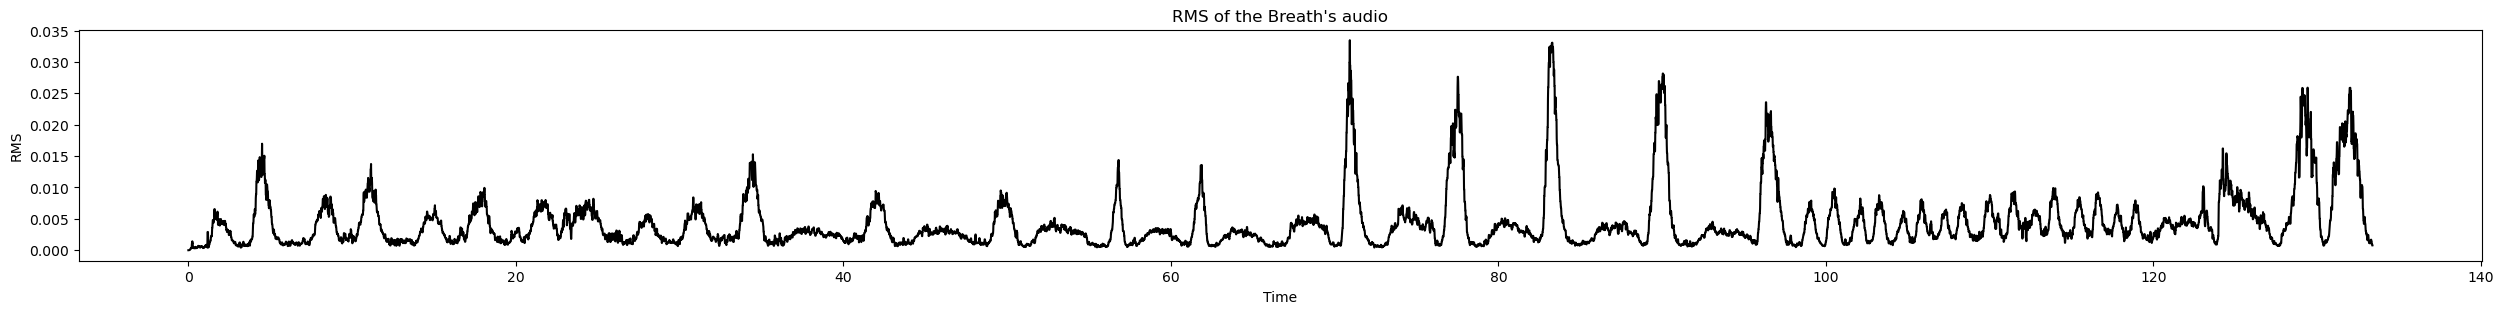

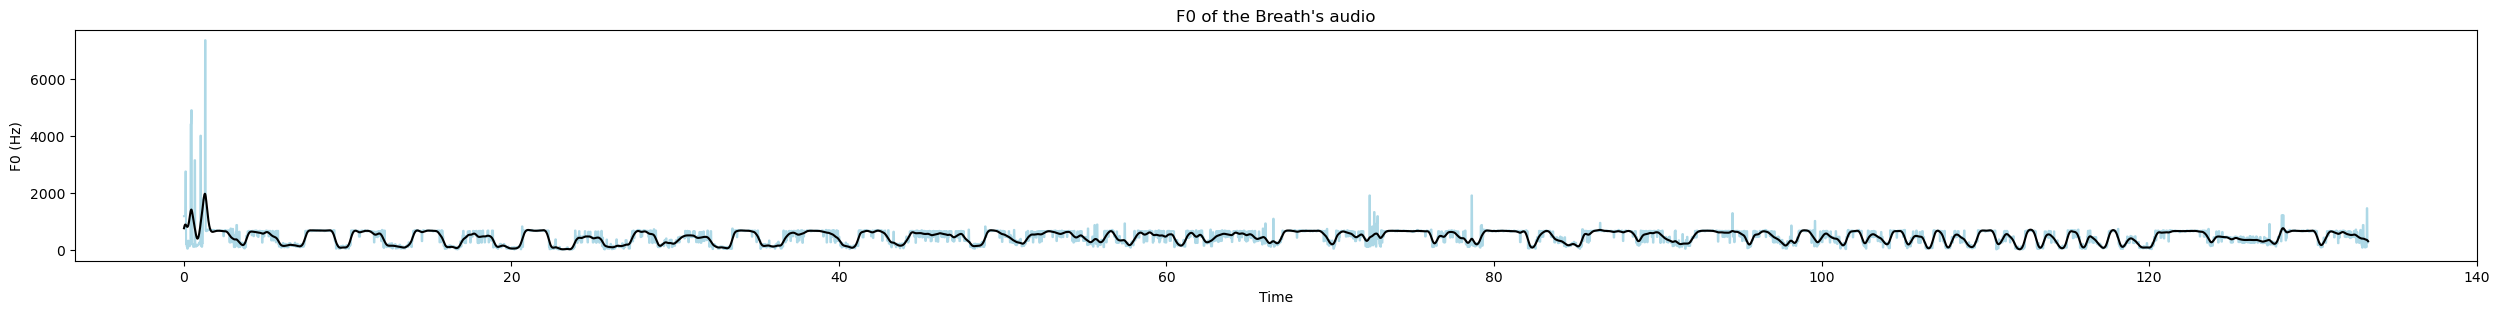

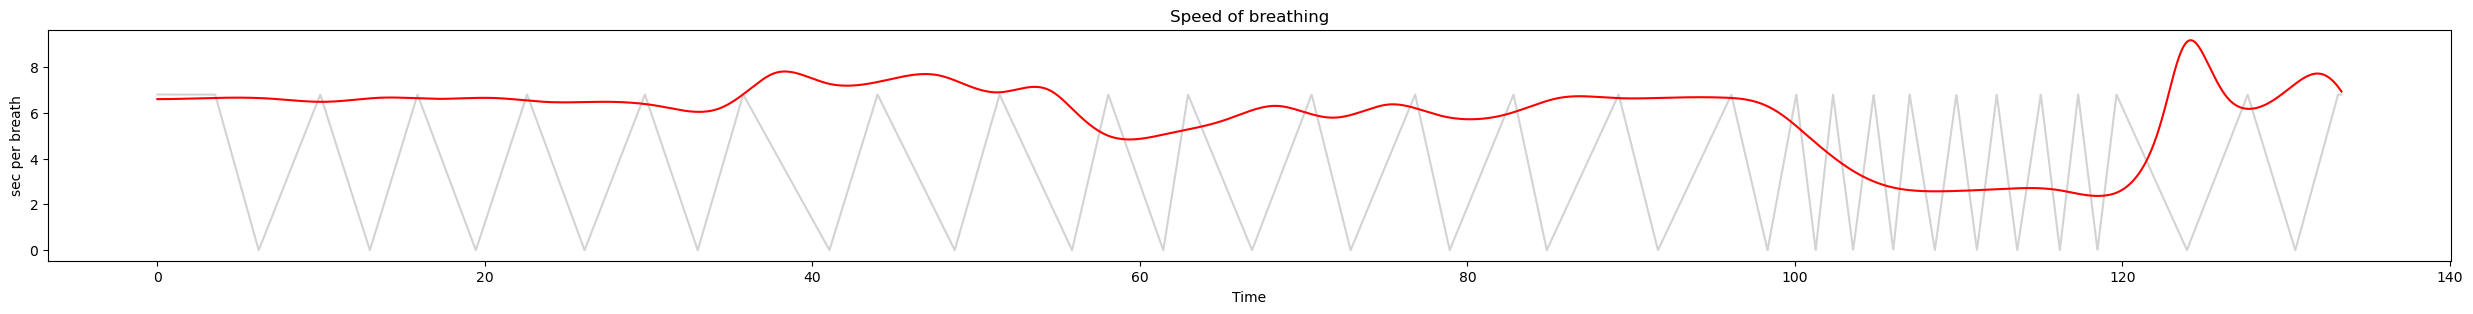

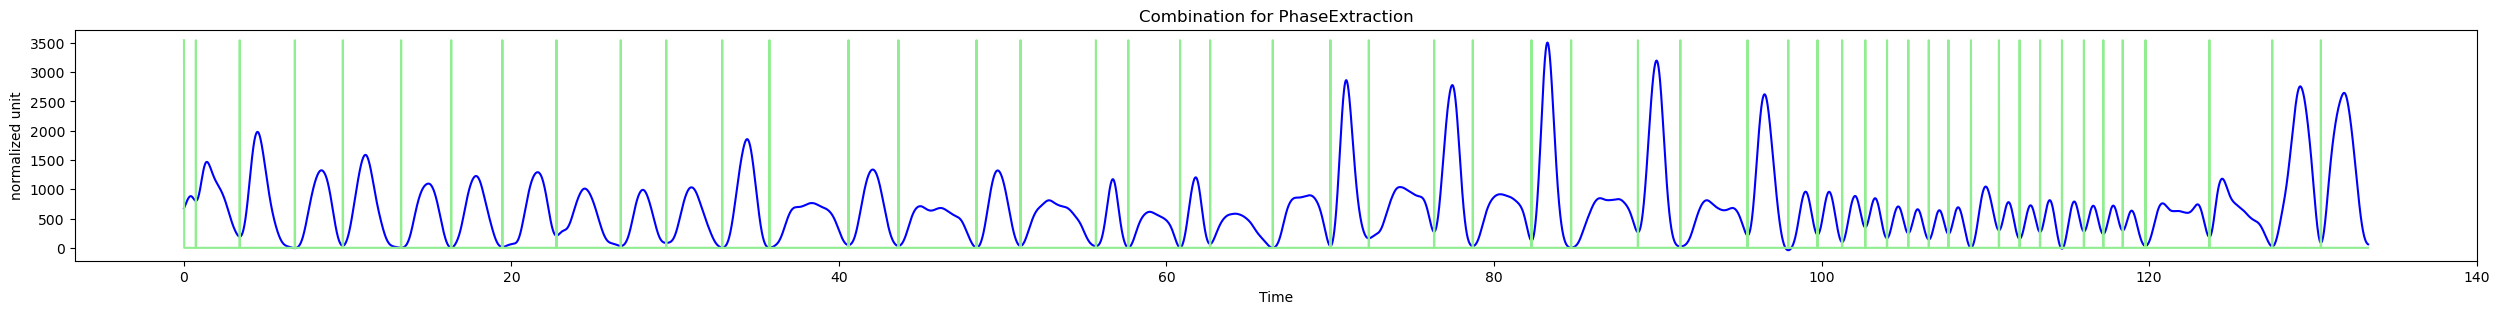

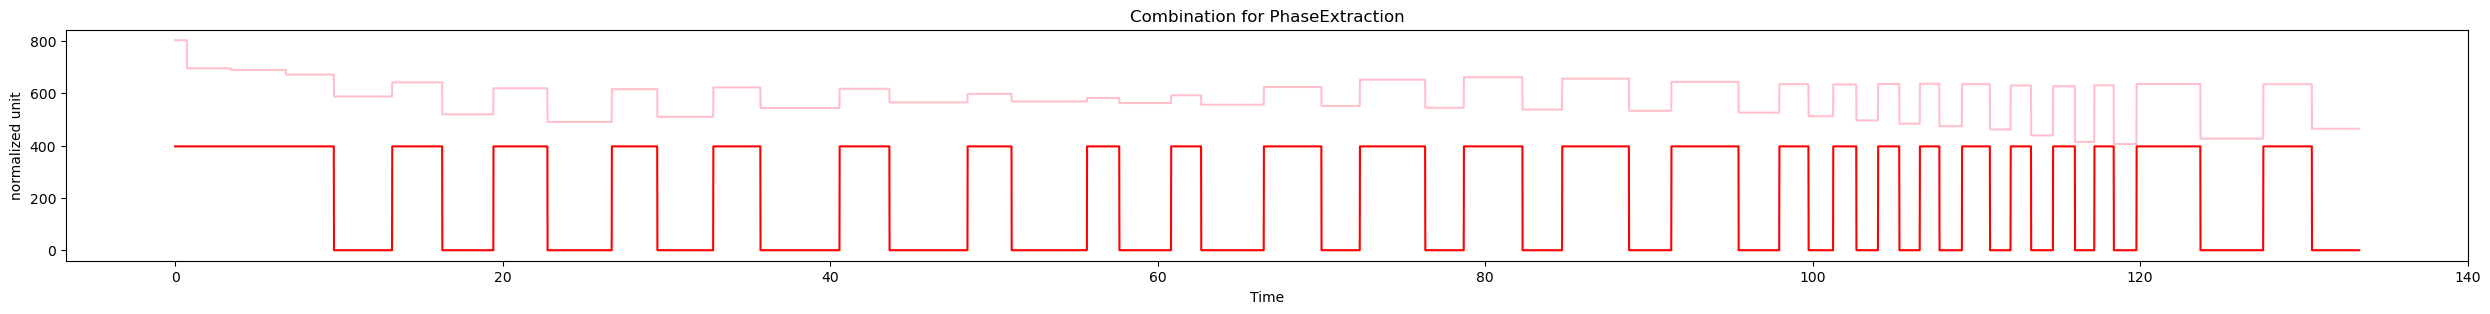

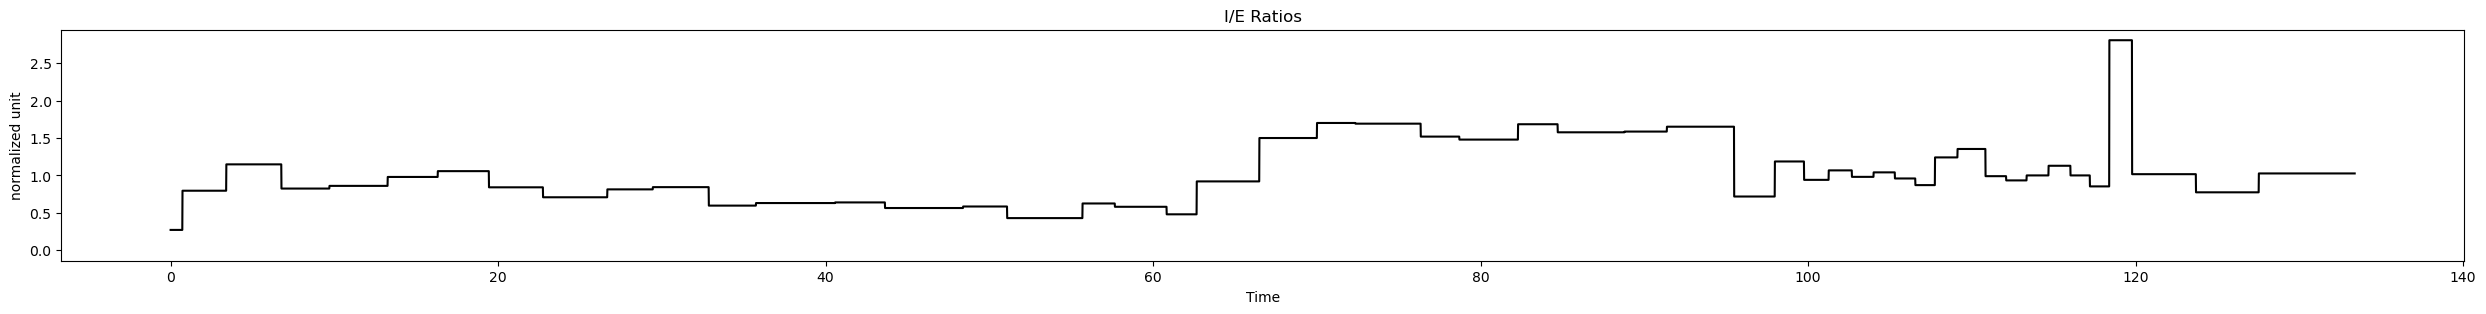

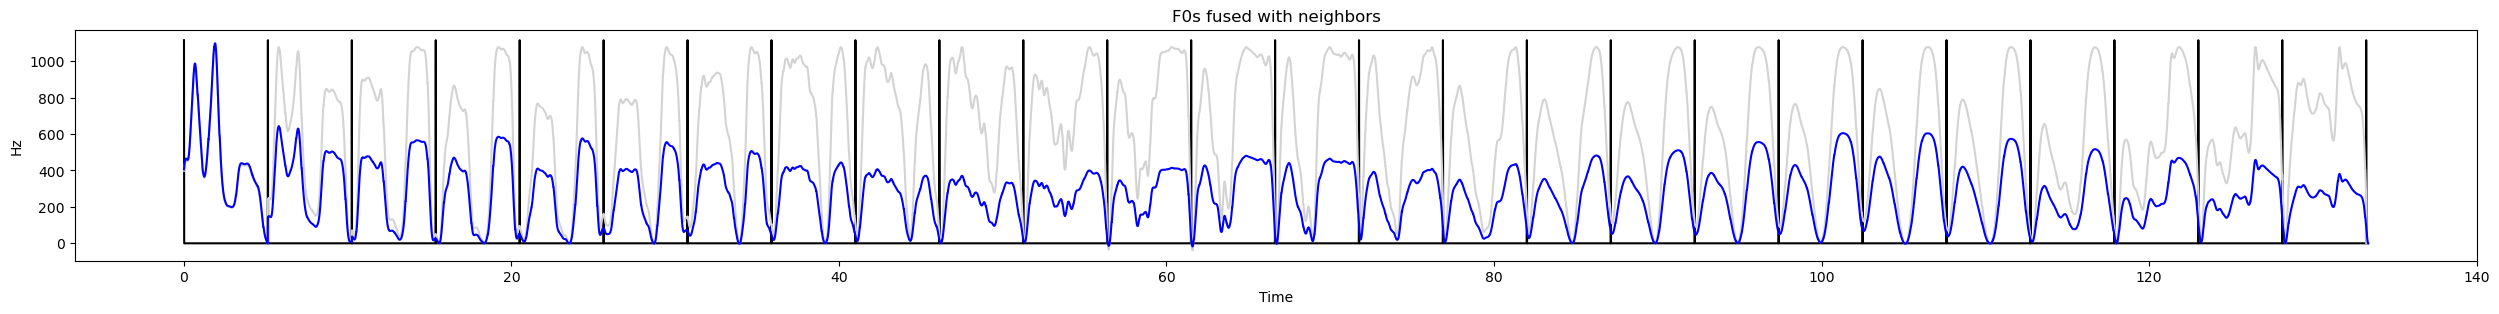

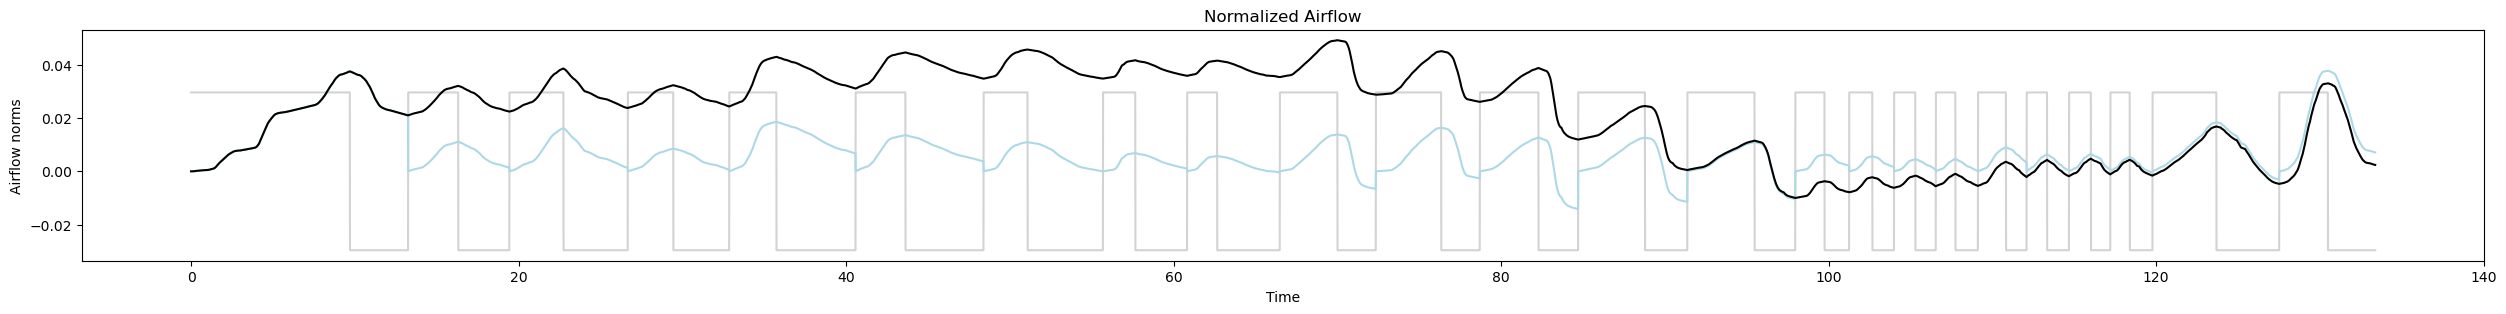

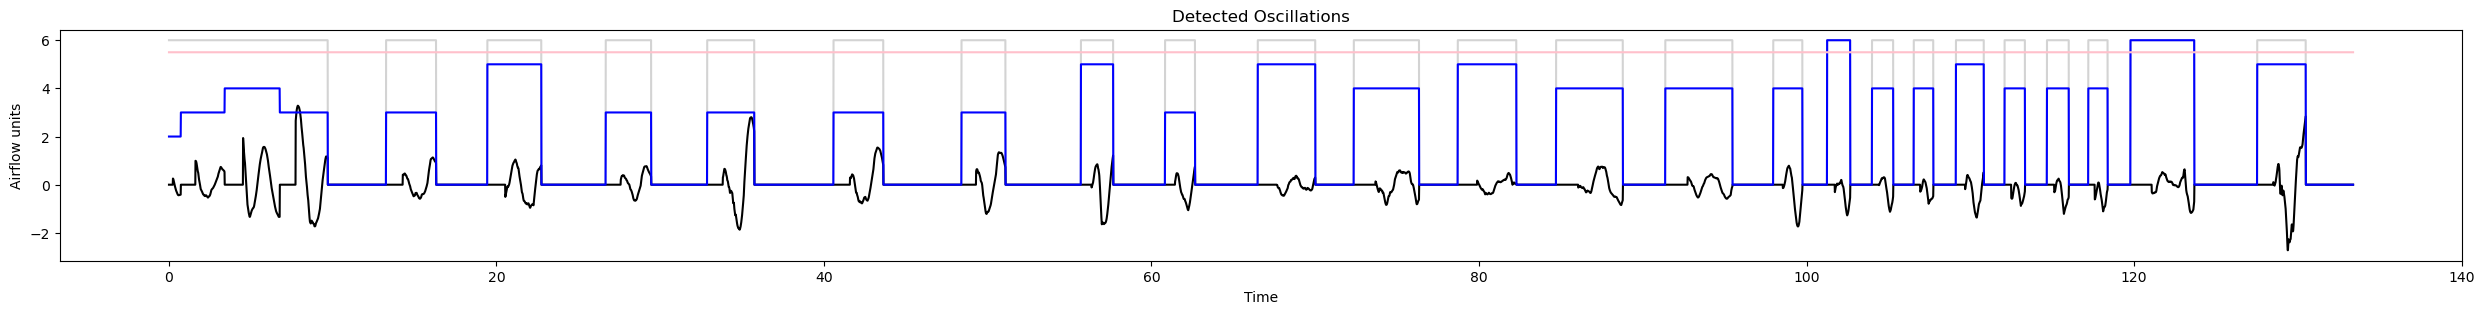

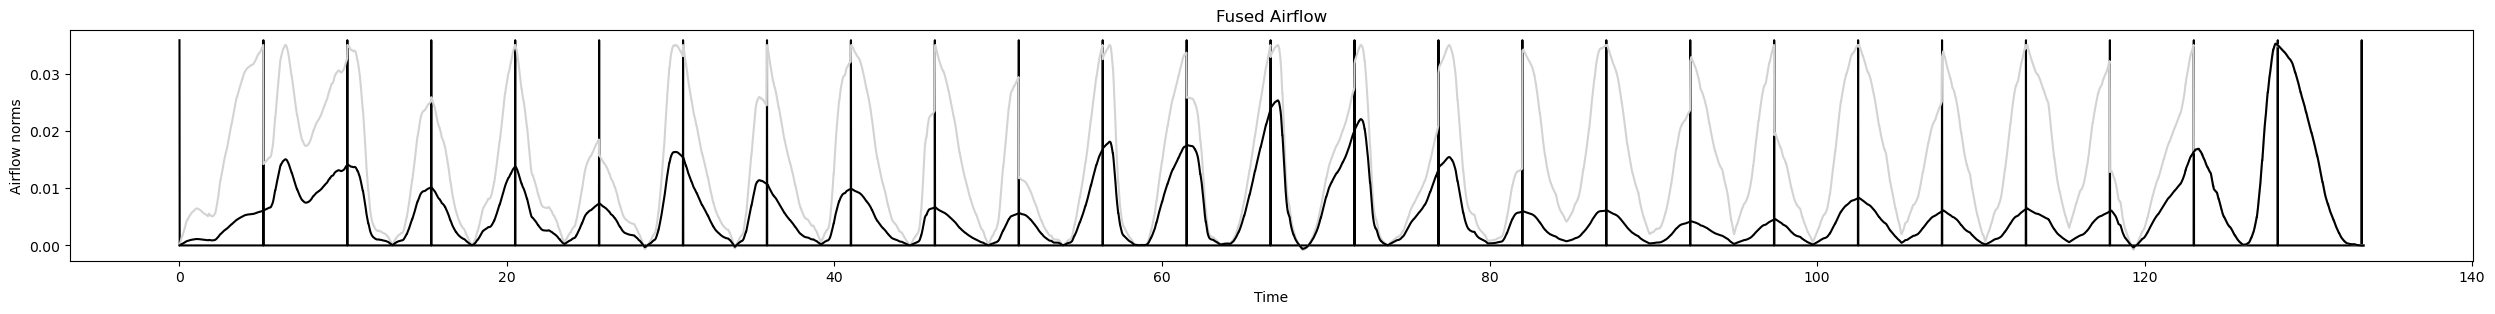

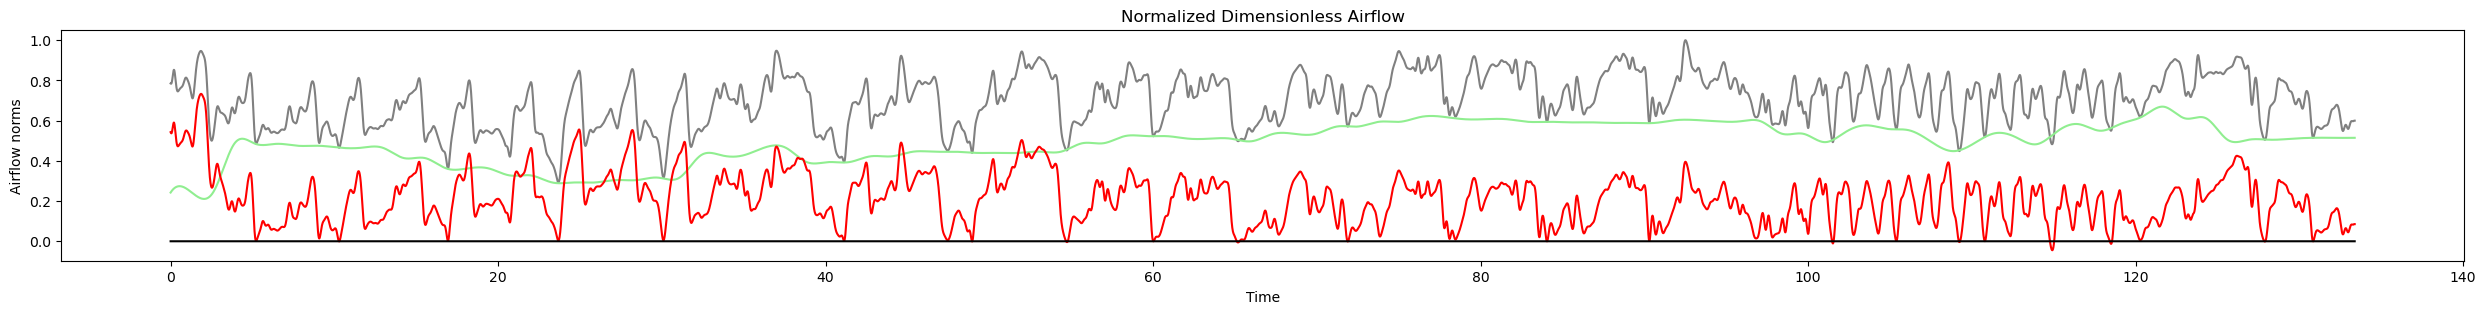

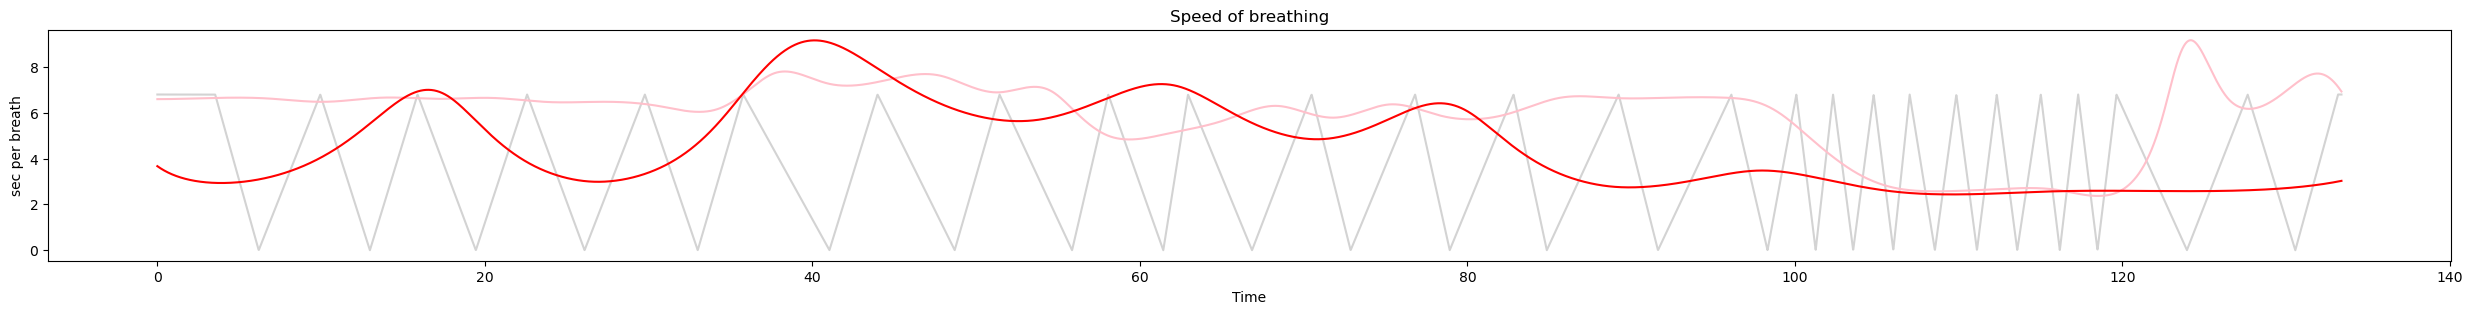

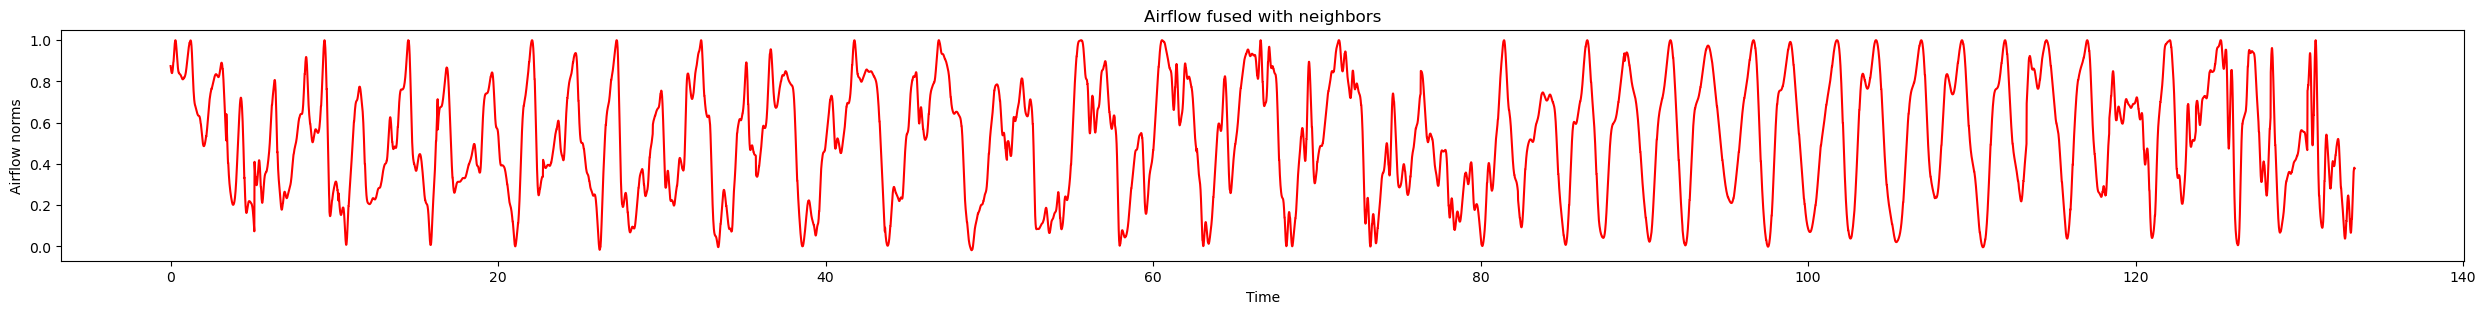

In [72]:
Audio(data=audioData, rate=sr)


# ---------- RMS ---------- 

rmsInTime = ComputeRMSAllignedToTime(audioData, sr)

PlottingOnTime(
    [[rmsInTime, "Breath Audio RMS", "black"]]
    , "RMS of the Breath's audio", "RMS")


# ----------  Foundamental Frequncy ---------- 

F0s = ComputeF0(audioData, sr)
filteredF0s = FilterF0(F0s)

PlottingOnTime(
    [[ F0s, "F0", "lightblue"], [filteredF0s, "filteredF0", "black"]]
    , "F0 of the Breath's audio", "F0 (Hz)")


# ----------  Breathing frequency from Boosted Autocorrelation ---------- 

combinedFeat = computeCombinedFeat(filteredF0s, rmsInTime)
BreathHzFromCombination = ComputeBreathingFrequency(combinedFeat, definition = 2)
SecPerBreathFormCombination = [ 1.0 /i for i in BreathHzFromCombination]
combinedFeat, combinedFeatBaseLine = SubtractBaseLine(combinedFeat, BreathHzFromCombination, tollerance = 0.9)
BreathHzFromCombination = ComputeBreathingFrequency(combinedFeat, definition = 5, freqApproximation= BreathHzFromCombination)
SecPerBreathFormCombination = [ 1.0 /i for i in BreathHzFromCombination]
choosedBreathinFreq = BreathHzFromCombination

PlottingOnTime(
    [[annotatedBreathing, "norm_actual", "lightgray"]
     ,[SecPerBreathFormCombination, "Breath speed from combination", "red"]]
    , "Speed of breathing", "sec per breath")


# ----------  Breaths unitization ---------- 

minimums, minsinTime = getBreathWindows(combinedFeat, tollerance = 0.7)

PlottingOnTime(
    [[combinedFeat, "Combination for PhaseExtraction", "blue"],
     [minsinTime, "norm_ minimus in Time", "lightgreen"]]
    , "Combination for PhaseExtraction", "normalized unit")


# ----------  Inspiration-Expiration Classification ---------- 

segmentedF0s, halfMinimums = segmentF0s(minimums, filteredF0s, variance = 2)
classification, parity = ClassifyIntoSpirationType(segmentedF0s, minimums)

PlottingOnTime(
    [[segmentedF0s, "breaths_F0 per phase", "pink"], [classification, "breaths_norm_classification spiration", "red"]]
    , "Combination for PhaseExtraction", "normalized unit")


# ----------  Inspiration-Expiration Ratios ---------- 

ieRatios = ComputeIERatios(minimums, classification, parity)

PlottingOnTime(
    [[ieRatios, "breaths_ I/E Ratios", "black"]]
    , "I/E Ratios", "normalized unit")


# ----------  Fused F0s with neighbors breaths + A normalization of each window ---------- 

lengthOfBreathReshaped = len(time) // len(halfMinimums)
reshapedRithm = np.arange(0, len(time), len(time) // (len(halfMinimums)-1))
reshapedRithmInTime = np.array([1 if i%(len(time) // (len(halfMinimums)-1)) == 0 else 0 for i in range(len(time))])

fusedF0s = FusePatternsAutocorrelated(filteredF0s, halfMinimums, lengthOfBreathReshaped, variance = 1) 
fusedF0s, baselineF = SubtractBaseLine(fusedF0s, [len(halfMinimums) / time[-1]]*len(fusedF0s), tollerance = 0)
fusedF0snormalized = normalizeInHeightSegmentedData(fusedF0s, reshapedRithm, 1)

PlottingOnTime(
    [ [reshapedRithmInTime, "norm_Reshaped Rithm", "black"], [fusedF0snormalized, "norm_F0s fused normalized", "lightgray"], [fusedF0s, "fused filteredF0s", "blue"]]
    , "F0s fused with neighbors", "Hz")


# ----------  AirFlow extraction thanks to classification of phases and (in future) ML over features ----------  

myAirFlow, myAirFlowUnBiased = ExtractAirflow(rmsInTime, filteredF0s, segmentedF0s, classification, minimums)

PlottingOnTime(
    [[[val -0.5 for val in classification], "breaths_norm_classification", "lightgray"], [myAirFlowUnBiased, "Airflow", "lightblue"]
     , [myAirFlow, "Airflow", "black"]]
    , "Normalized Airflow", "Airflow norms")


# ----------  Oscillation Detenction ----------

myAirFlowToBottom, baselineAir = SubtractBaseLine(myAirFlow, [len(halfMinimums) / time[-1]]*len(myAirFlow),  tollerance = -0.2)
detectedOscillation, zeroCrossingOut = DetectOscillations(myAirFlowToBottom, minimums)

PlottingOnTime(
    [[classification, "breaths_norm_classification", "lightgray"],[detectedOscillation, "norm_detected oscillation", "black"]
    , [zeroCrossingOut, "oscillations with zero crossing", "blue"], [[5.5]*len(time), "threshold", "pink"]]
    , "Detected Oscillations", "Airflow units")


# ----------  Fused Airflow with neighbors breaths + A normalization of each window ---------- 

myAirFlowToBottomFused = FusePatternsAutocorrelated(myAirFlowToBottom, halfMinimums, lengthOfBreathReshaped, variance = None)
myAirFlowNormalized = normalizeInHeightSegmentedData(myAirFlowToBottomFused, reshapedRithm, 1)

PlottingOnTime(
    [[reshapedRithmInTime, "norm_Reshaped Rithm", "black"], [myAirFlowNormalized, "norm_Airflow fused normalized", "lightgray"], [myAirFlowToBottomFused, "Airflow fused", "black"]]
    , "Fused Airflow", "Airflow norms")




# -----------------------------------------------------------------------------------------------------------------------------------
#                              In the condition of a reliable set of data coming from an stetoskope
# -----------------------------------------------------------------------------------------------------------------------------------

if(airFlow_file_path != None):

    # ----------  Airflow extracted from the Audio with the openSource deep learning algorithm ---------- 
    
    wavedAirFlowData, airFlowbaseLine = SubtractBaseLine(airFlowData, choosedBreathinFreq, 0);

    PlottingOnTime(
        [[airFlowData, "Normalized Airflow", "grey"], [airFlowbaseLine, "base line", "lightgreen"]
         , [wavedAirFlowData, "Waved Airflow", "red"],  [np.zeros(len(time)), "", "black"] ]
        , "Normalized Dimensionless Airflow", "Airflow norms")

    
    # ----------  Speed of breathing, expressed as how many seconds per breath, calculated through Autocorrelation ---------- 
    
    BreathHz = ComputeBreathingFrequency(wavedAirFlowData, definition = 2)
    SecPerBreath = [ 1.0 /i for i in BreathHz]

    PlottingOnTime(
        [[annotatedBreathing, "norm_actual", "lightgray"], [SecPerBreathFormCombination, "Breath speed from combination", "pink"], [SecPerBreath, "Breath speed", "red"]]
        , "Speed of breathing", "sec per breath")


    # ----------  Fusion of the local breaths into one shape ---------- 
    
    fusedAirFlowData = FusePatternsAutocorrelated(wavedAirFlowData, halfMinimums, lengthOfBreathReshaped)
    fusedAirFlowData, baselineA = SubtractBaseLine(fusedAirFlowData, [len(halfMinimums) / time[-1]]*len(fusedAirFlowData), tollerance = 0)
    fusedAirFlowData = normalizeInHeightSegmentedData(fusedAirFlowData, halfMinimums, 1)

    PlottingOnTime(
        [ [fusedAirFlowData, "fused Airflow", "red"]]
        , "Airflow fused with neighbors", "Airflow norms")


# Appendix

<img src="https://i.imgur.com/3j8BPdc.png" style="height:300px" >